In [1]:
import os
import sys

import numpy as np
import pandas as pd
import tabula

import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.plot import (
    heatmap,
    plot_bar,
    plot_hist,
    plot_pie,
    PRIMARY_CMAP,
    PRIMARY_HEX,
    SECONDARY_HEX,
    TERTIARY_HEX,
)

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/pa_claims"
OUTPUT_DATA_DIR = "./output_data/pa_claims"  # Set to None if you don't want to save non-required data for external use
NO_PLOT_TITLES = False  # If True, plots have no titles. Useful for cases where one wants titles rendered separately from underlying plots.

In [2]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

issuer_path = os.path.join(OUTPUT_DATA_DIR, "pa_issuers.csv")
plan_path = os.path.join(OUTPUT_DATA_DIR, "pa_plans.csv")

In [3]:
def get_issuer_data(pdf_path):
    # Get issuer level data from first page
    issuer1_area = (171, 51, 562, 378)
    issuer1 = tabula.read_pdf(pdf_path, pages=1, area=issuer1_area)[0]
    plan_year_reporting = int(issuer1.iloc[0, 0][-6:-2])
    plan_year = plan_year_reporting + 2

    # Get issuer level data from second page
    issuer2_area = (171, 51, 600, 378)
    issuer2 = tabula.read_pdf(
        pdf_path,
        pages=2,
        area=issuer2_area,
        multiple_tables=False,
        stream=True,
        pandas_options={"header": None},
    )[0]

    # Get metadata values
    issuer_values = issuer2.iloc[:, 0].values
    on_exchange_in_plan_year_reporting = True if issuer_values[0] == "Yes" else False
    sadp_only = True if issuer_values[1] == "Yes" else False
    hios_issuer_id = int(issuer_values[2])

    # Claims
    claims_received = (
        int(issuer_values[3].replace(",", ""))
        if not pd.isna(issuer_values[3])
        else None
    )
    claims_denied = (
        int(issuer_values[4].replace(",", ""))
        if not pd.isna(issuer_values[4])
        else None
    )
    internal_appeals = (
        int(issuer_values[5].replace(",", ""))
        if not pd.isna(issuer_values[5])
        else None
    )
    internal_appeal_overturns = (
        int(issuer_values[6].replace(",", ""))
        if not pd.isna(issuer_values[6])
        else None
    )
    external_appeals = (
        int(issuer_values[7].replace(",", ""))
        if not pd.isna(issuer_values[7])
        else None
    )
    external_appeal_overturns = (
        int(issuer_values[8].replace(",", ""))
        if not pd.isna(issuer_values[8])
        else None
    )

    return (
        hios_issuer_id,
        plan_year,
        plan_year_reporting,
        sadp_only,
        claims_received,
        claims_denied,
        internal_appeals,
        internal_appeal_overturns,
        external_appeals,
        external_appeal_overturns,
    )


def convert_comma_string_to_int(val):
    if type(val) is not str:
        val = str(val)
        val = val.replace(".0", "")
    # Remove commas in strs, and erroneous str entries
    val = int(val.replace(",", "")) if val != "N/A" else None
    return val


def get_plan_data(pdf_path, plan_year, issuer_id):
    # Get total pdf page length
    reader = pypdf.PdfReader(open(pdf_path, mode="rb"))
    num_pages = len(reader.pages)

    if num_pages < 3:
        return pd.DataFrame()

    # Hardcode starting page in pdfs for plan-level data
    start_page = 3

    p_area = (171, 51, 800, 378)
    plans = tabula.read_pdf(
        pdf_path,
        pages=f"{start_page}-{num_pages}",
        guess=False,
        lattice=True,
        multiple_tables=True,
        pandas_options={"header": None},
    )

    plan_dfs = []

    # We will iterate over vertically split pieces within horizontally split pieces
    # Table is split horizontally into 3 pieces.
    # Number of vertical pieces for each horizontal piece varies by pdf, depending on total num records in table
    horizontal_pieces = 3
    assert len(plans) % horizontal_pieces == 0
    num_vertical_pieces = len(plans) // horizontal_pieces

    # Subsequent pages can be handled with consistent logic
    # Since no need to drop a row
    for pg_num in range(0, len(plans), num_vertical_pieces):
        vertical_pieces = []
        for voffset in range(0, num_vertical_pieces):
            p = plans[pg_num + voffset]
            if voffset == 0:
                if pg_num == 0:
                    p = p.drop(labels=0, axis=0).reset_index(drop=True)
                p.columns = p.iloc[0]
                p = p.drop(axis=0, labels=0)
            vertical_pieces.append(p)
        vertical_piece = pd.DataFrame(np.vstack(vertical_pieces))
        vertical_piece.columns = vertical_pieces[0].columns
        plan_dfs.append(vertical_piece)

    # Drop complete NA dfs that appear
    plan_dfs = [df for df in plan_dfs if not df.isnull().values.all()]

    # Drop complete NA rows
    df = pd.concat(plan_dfs, axis=1).dropna(how="all")

    # Add plan year column
    df["current_plan_year"] = plan_year
    df["data_plan_year"] = plan_year - 2

    # Add issuer id column
    df["hios_issuer_id"] = issuer_id

    # Rename columns
    df.columns = [
        "plan_id",
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
        "notes",
        "current_plan_year",
        "data_plan_year",
        "hios_issuer_id",
    ]

    # Cast int cols
    int_cols = [
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
    ]
    for int_col in int_cols:
        df[int_col] = (
            df[int_col].apply(convert_comma_string_to_int).astype(dtype="Int64")
        )

    return df


def convert_comma_string_to_int(val):
    if type(val) is not str:
        val = str(val)
        val = val.replace(".0", "")
    # Remove commas in strs, and erroneous str entries
    val = int(val.replace(",", "")) if val != "N/A" else None
    return val


def get_plan_data(pdf_path, plan_year, issuer_id):
    # Get total pdf page length
    reader = pypdf.PdfReader(open(pdf_path, mode="rb"))
    num_pages = len(reader.pages)

    if num_pages < 3:
        return pd.DataFrame()

    # Hardcode starting page in pdfs for plan-level data
    start_page = 3

    p_area = (171, 51, 800, 378)
    plans = tabula.read_pdf(
        pdf_path,
        pages=f"{start_page}-{num_pages}",
        guess=False,
        lattice=True,
        multiple_tables=True,
        pandas_options={"header": None},
    )

    plan_dfs = []

    # We will iterate over vertically split pieces within horizontally split pieces
    # Table is split horizontally into 3 pieces.
    # Number of vertical pieces for each horizontal piece varies by pdf, depending on total num records in table
    horizontal_pieces = 3
    assert len(plans) % horizontal_pieces == 0
    num_vertical_pieces = len(plans) // horizontal_pieces

    # Subsequent pages can be handled with consistent logic
    # Since no need to drop a row
    for pg_num in range(0, len(plans), num_vertical_pieces):
        vertical_pieces = []
        for voffset in range(0, num_vertical_pieces):
            p = plans[pg_num + voffset]
            if voffset == 0:
                if pg_num == 0:
                    p = p.drop(labels=0, axis=0).reset_index(drop=True)
                p.columns = p.iloc[0]
                p = p.drop(axis=0, labels=0)
            vertical_pieces.append(p)
        vertical_piece = pd.DataFrame(np.vstack(vertical_pieces))
        vertical_piece.columns = vertical_pieces[0].columns
        plan_dfs.append(vertical_piece)

    # Drop complete NA dfs that appear
    plan_dfs = [df for df in plan_dfs if not df.isnull().values.all()]

    # Drop complete NA rows
    df = pd.concat(plan_dfs, axis=1).dropna(how="all")

    # Add plan year column
    df["current_plan_year"] = plan_year
    df["data_plan_year"] = plan_year - 2

    # Add issuer id column
    df["hios_issuer_id"] = issuer_id

    # Rename columns
    df.columns = [
        "plan_id",
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
        "notes",
        "current_plan_year",
        "data_plan_year",
        "hios_issuer_id",
    ]

    # Cast int cols
    int_cols = [
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
    ]
    for int_col in int_cols:
        df[int_col] = (
            df[int_col].apply(convert_comma_string_to_int).astype(dtype="Int64")
        )

    return df

In [4]:
# Logic for extracting data from public records
# Horrible, but it got the job done, and can ideally be re-used for future records requests.
# Public records now hosted here: https://repos.persius.org/public-records/data/claims_denials/pa/readme.html
# The notebook proceeds by using these data that were extracted from the raw public records.
# If you'd instead like to reproduce our extraction of the data from the raw public records, use
# the code below.

# import pypdf
# data_dir = "/home/mike/persius/Public Records Request/PA/rtkl01609"
# pdf_paths = glob.glob(f"{data_dir}/**")


# # Issuer level, plan year claims denial data format:
# insurer_names = []
# issuer_hios_ids = []
# plan_years_reporting = []
# plan_years = []
# sadp_only_statuses = []
# claims_received = []  # received and DOS in plan_year
# claims_denied = []
# internal_appeals = []
# internal_appeal_overturns = []
# external_appeals = []
# external_appeal_overturns = []
# plan_dfs = []

# for pdf_path in pdf_paths:
#     try:
#         insurer_name = " ".join(pdf_path.split("/")[-1].split("-")[0].split(" ")[:-1])

#         # Get insurer-level data
#         (
#             hios_issuer_id,
#             plan_year,
#             plan_year_reporting,
#             sadp_only,
#             issuer_claims_received,
#             issuer_claims_denied,
#             issuer_internal_appeals,
#             issuer_internal_appeal_overturns,
#             issuer_external_appeals,
#             issuer_external_appeal_overturns,
#         ) = get_issuer_data(pdf_path)

#         # Append insurer-level data
#         insurer_names.append(insurer_name)
#         issuer_hios_ids.append(hios_issuer_id)
#         plan_years_reporting.append(plan_year_reporting)
#         plan_years.append(plan_year)
#         sadp_only_statuses.append(sadp_only)
#         claims_received.append(issuer_claims_received)
#         claims_denied.append(issuer_claims_denied)
#         internal_appeals.append(issuer_internal_appeals)
#         internal_appeal_overturns.append(issuer_internal_appeal_overturns)
#         external_appeals.append(issuer_external_appeals)
#         external_appeal_overturns.append(issuer_external_appeal_overturns)

#         # Get plan-level data
#         plan_data = get_plan_data(
#             pdf_path, plan_year=plan_year, issuer_id=hios_issuer_id
#         )
#         if len(plan_data) > 0:
#             plan_dfs.append(plan_data)

#     except Exception as e:
#         print(pdf_path)
#         print(e)

# issuer_df = pd.DataFrame(
#     data={
#         "insurer_name": pd.Series(insurer_names, dtype=str),
#         "hios_id": pd.Series(issuer_hios_ids, dtype=int),
#         "data_plan_year": pd.Series(plan_years_reporting, dtype=int),
#         "current_plan_year": pd.Series(plan_years, dtype=int),
#         "sadp_only": sadp_only_statuses,
#         "claims_received": pd.Series(claims_received, dtype="Int64"),
#         "claims_denied": pd.Series(claims_denied, dtype="Int64"),
#         "internal_appeals": pd.Series(internal_appeals, dtype="Int64"),
#         "internal_appeal_overturns": pd.Series(
#             internal_appeal_overturns, dtype="Int64"
#         ),
#         "external_appeals": pd.Series(external_appeals, dtype="Int64"),
#         "external_appeal_overturns": pd.Series(
#             external_appeal_overturns, dtype="Int64"
#         ),
#     }
# )

# plan_df = pd.concat(plan_dfs, axis=0)

# # Write dfs
# issuer_df.to_csv(issuer_path, index=False)
# plan_df.to_csv(plan_path, index=False)

In [5]:
# Read dfs
issuers_url = "https://repos.persius.org/public-records/data/claims_denials/pa/processed/issuers.csv"
plans_url = "https://repos.persius.org/public-records/data/claims_denials/pa/processed/plans.csv"
issuer_df = pd.read_csv(issuers_url)
plan_df = pd.read_csv(plans_url)

In [6]:
# High level dataset stats

# Marketplace (and possibly some fully insured group?)
issuer_claims = issuer_df["claims_received"].sum()
issuer_denials = issuer_df["claims_denied"].sum()
issuer_internal_appeals = issuer_df["internal_appeals"].sum()
issuer_external_appeals = issuer_df["external_appeals"].sum()
print(
    f"Issuers: {len(issuer_df['hios_id'].unique())}\n",
    f"Issuer level claims: {issuer_claims}\n",
    f"Issuer level denials: {issuer_denials}\n",
    f"Issuer level internal appeals: {issuer_internal_appeals}\n",
    f"Issuer level external appeals: {issuer_external_appeals}\n",
)

# Marketplace only
plan_claims = plan_df["claims_received"].sum()
plan_denials = plan_df["claims_denied"].sum()
print(
    f"Issuers: {len(plan_df['hios_issuer_id'].unique())}\n",
    f"Plans: {len(plan_df['plan_id'].unique())}\n",
    f"Plan level claims: {plan_claims}\n",
    f"Plan level denials: {plan_denials}\n",
)

print(
    f"Diff Claims (Issuer - Plan level): {issuer_claims - plan_claims}\n",
    f"Diff Denials (Issuer - Plan level): {issuer_denials - plan_denials}\n",
)

Issuers: 13
 Issuer level claims: 21646696.0
 Issuer level denials: 2964421.0
 Issuer level internal appeals: 2751.0
 Issuer level external appeals: 103.0

Issuers: 13
 Plans: 599
 Plan level claims: 19946731.0
 Plan level denials: 2619400.0

Diff Claims (Issuer - Plan level): 1699965.0
 Diff Denials (Issuer - Plan level): 345021.0



## Issuer Data

In [7]:
# TODO: Submit inquiry about lack of data for certain issuers (e.g. Independence)

In [8]:
# Throw out issuer records with unbelievable claims numbers (e.g. 1 claim in 2021)
MIN_CLAIMS = 100
issuer_df = issuer_df[issuer_df["claims_received"] >= MIN_CLAIMS]

In [9]:
def get_overall_issuer_rates(issuer_df: pd.DataFrame):
    # Add relevant issuer level rates
    # Note: this data includes non-marketplace plans info (unlike plan level df)
    df = issuer_df
    df["denial_rate"] = df["claims_denied"] / df["claims_received"]
    df["internal_appeal_rate"] = df["internal_appeals"] / df["claims_denied"]
    df["internal_appeal_success_rate"] = (
        df["internal_appeal_overturns"] / df["internal_appeals"]
    )
    df["external_appeal_rate"] = df["external_appeals"] / (
        df["internal_appeals"] - df["internal_appeal_overturns"]
    )
    df["external_appeal_success_rate"] = (
        df["external_appeal_overturns"] / df["external_appeals"]
    )

    # Compute totals across issuers
    issuer_claims_received = df["claims_received"].sum()
    issuer_denials = df["claims_denied"].sum()
    issuer_internal_appeals = df["internal_appeals"].sum()
    issuer_internal_appeal_overturns = df["internal_appeal_overturns"].sum()
    issuer_external_appeals = df["external_appeals"].sum()
    issuer_external_appeal_overturns = df["external_appeal_overturns"].sum()

    overall_denial_rate = issuer_denials / issuer_claims_received
    overall_internal_appeal_rate = issuer_internal_appeals / issuer_denials
    overall_internal_appeal_success_rate = (
        issuer_internal_appeal_overturns / issuer_internal_appeals
    )
    overall_external_appeal_rate = issuer_external_appeals / (
        issuer_internal_appeals - issuer_internal_appeal_overturns
    )
    overall_external_appeal_success_rate = (
        issuer_external_appeal_overturns / issuer_external_appeals
    )

    print(f"\tOverall denial rate: {overall_denial_rate:.2}")
    print(f"\tOverall internal appeal rate: {overall_internal_appeal_rate:.2}")
    print(
        f"\tOverall internal appeal success rate: {overall_internal_appeal_success_rate:.2}"
    )
    print(f"\tOverall external appeal rate: {overall_external_appeal_rate:.2}")
    print(
        f"\tOverall external appeal success rate: {overall_external_appeal_success_rate:.2}"
    )
    return df


def get_overall_issuer_rates_by_year(issuer_df: pd.DataFrame, data_year: int) -> tuple:
    """Get aggregate denial and appeal rates across issuers."""
    df = issuer_df[issuer_df["data_plan_year"] == data_year].copy(deep=True)

    df = get_overall_issuer_rates(df)

    return df

In [10]:
year_dfs = []
for year in issuer_df["data_plan_year"].unique():
    print(f"{year} issuer data:")
    year_df = get_overall_issuer_rates_by_year(issuer_df, year)
    year_dfs.append(year_df)

2021 issuer data:
	Overall denial rate: 0.15
	Overall internal appeal rate: 0.00074
	Overall internal appeal success rate: 0.59
	Overall external appeal rate: 0.078
	Overall external appeal success rate: 0.23
2020 issuer data:
	Overall denial rate: 0.13
	Overall internal appeal rate: 0.0012
	Overall internal appeal success rate: 0.6
	Overall external appeal rate: 0.1
	Overall external appeal success rate: 0.27


In [11]:
print("Combined_data:\n")
agg_map = {
    "insurer_name": "first",
    "data_plan_year": "first",
    "current_plan_year": "first",
    "sadp_only": "first",
    "claims_received": "sum",
    "claims_denied": "sum",
    "internal_appeals": "sum",
    "internal_appeal_overturns": "sum",
    "external_appeals": "sum",
    "external_appeal_overturns": "sum",
}
issuer_df = get_overall_issuer_rates(
    issuer_df.groupby(["hios_id"], as_index=False).agg(agg_map)
)

Combined_data:

	Overall denial rate: 0.14
	Overall internal appeal rate: 0.00093
	Overall internal appeal success rate: 0.59
	Overall external appeal rate: 0.091
	Overall external appeal success rate: 0.25


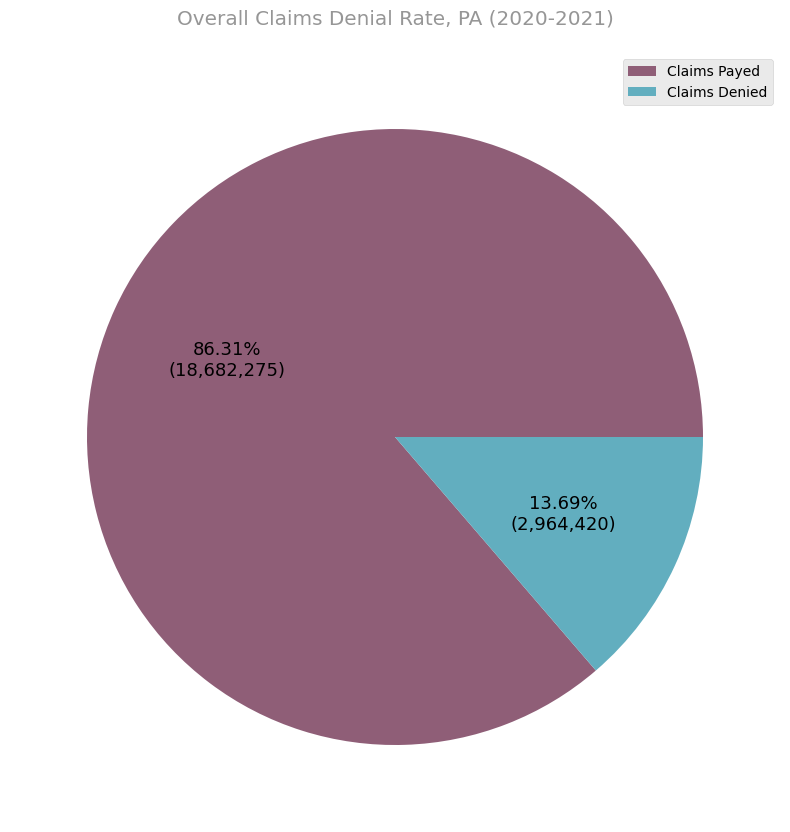

In [12]:
total_claims_received = issuer_df["claims_received"].sum()
total_claims_denied = issuer_df["claims_denied"].sum()

plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_claims_received - total_claims_denied, total_claims_denied],
    title="Overall Claims Denial Rate, PA (2020-2021)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie.png"),
)

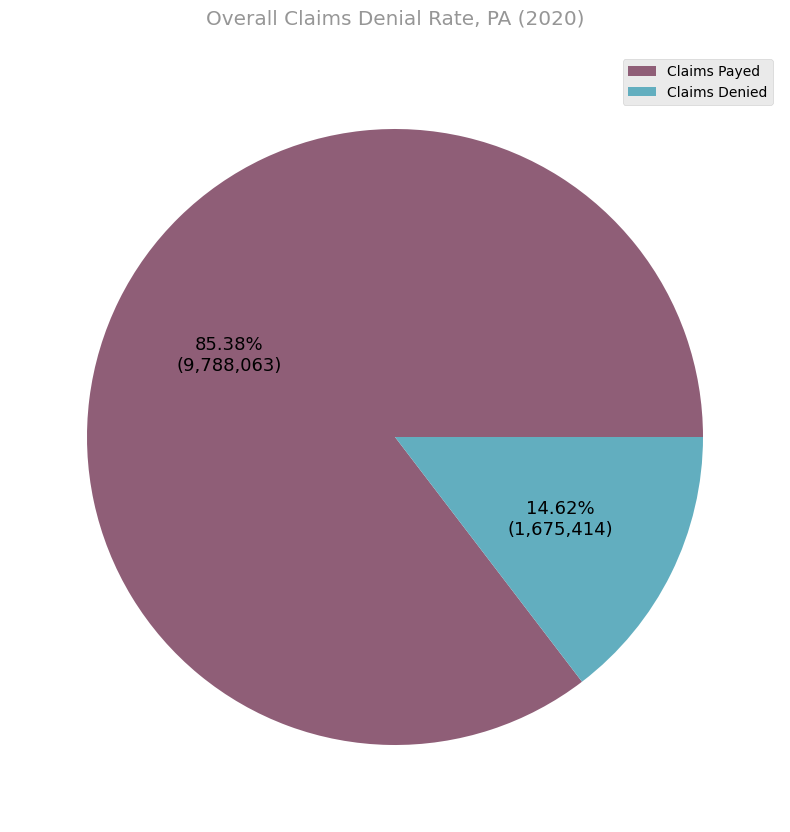

In [13]:
issuer_2020 = year_dfs[0]
total_claims_received = issuer_2020["claims_received"].sum()
total_claims_denied = issuer_2020["claims_denied"].sum()

plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_claims_received - total_claims_denied, total_claims_denied],
    title="Overall Claims Denial Rate, PA (2020)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie_2020.png"),
)

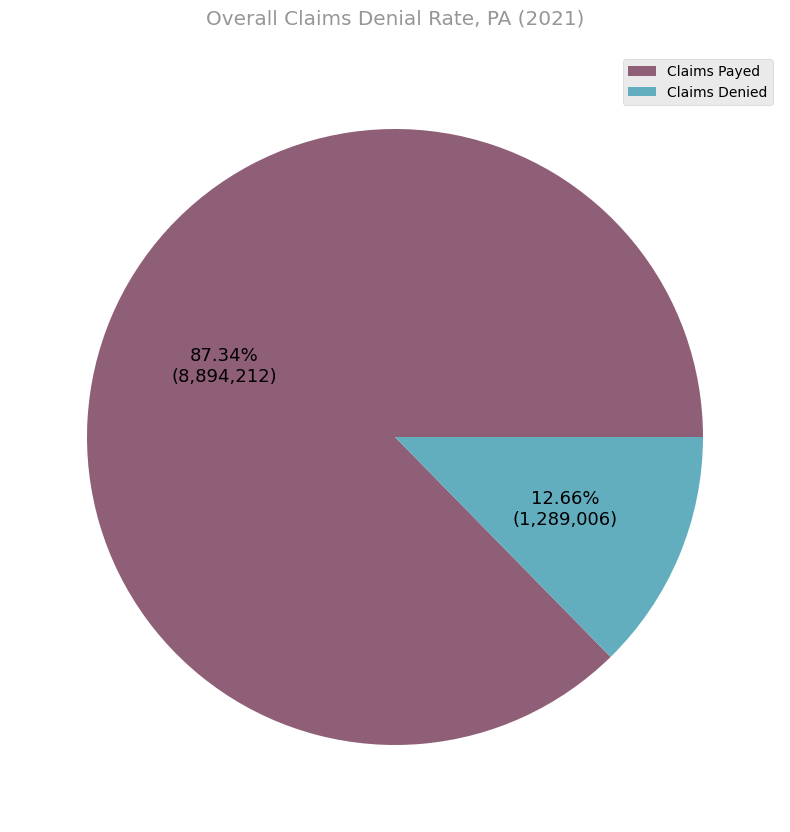

In [14]:
issuer_2020 = year_dfs[1]
total_claims_received = issuer_2020["claims_received"].sum()
total_claims_denied = issuer_2020["claims_denied"].sum()

plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_claims_received - total_claims_denied, total_claims_denied],
    title="Overall Claims Denial Rate, PA (2021)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie_2021.png"),
)

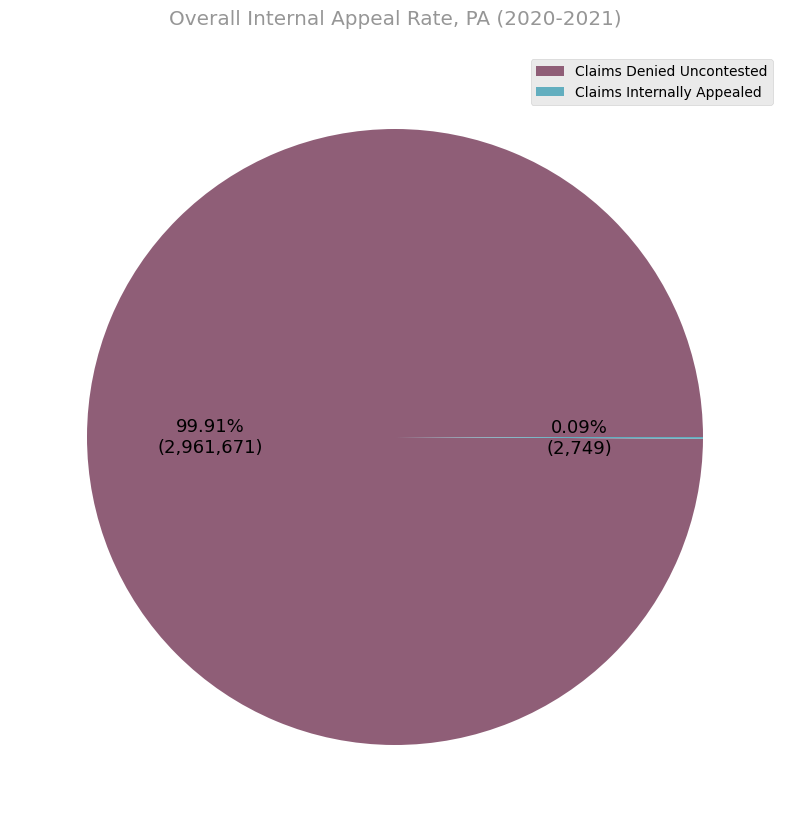

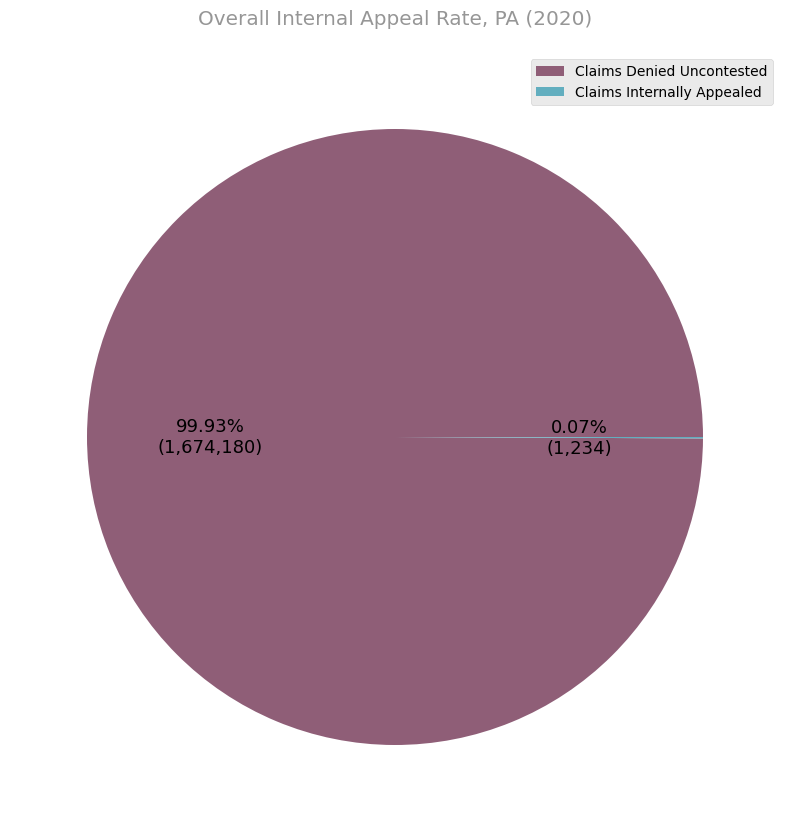

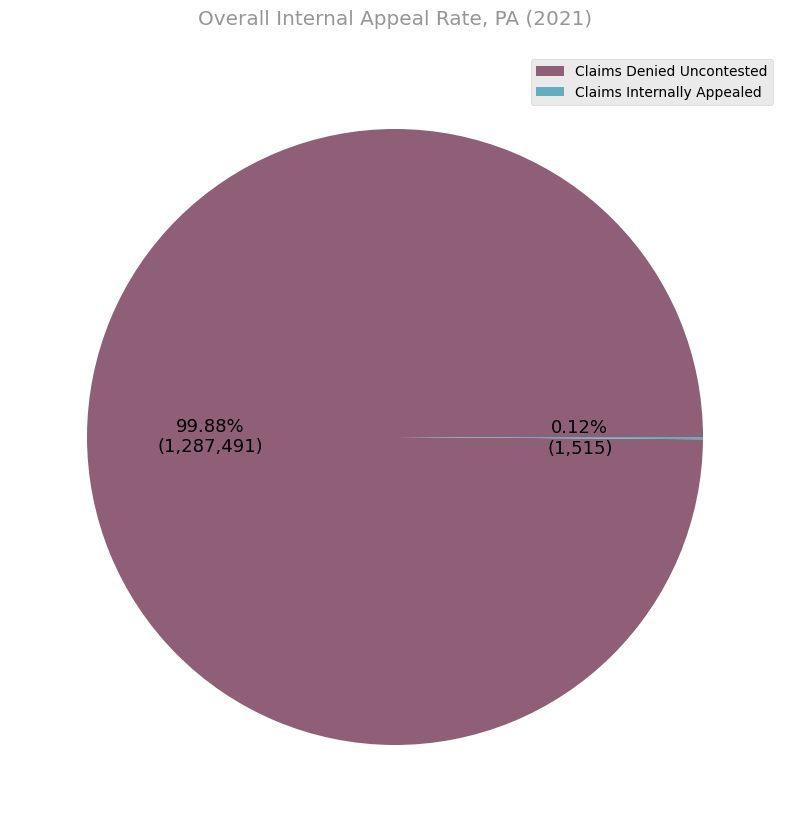

In [15]:
# Initial appeal rate
total_appealed = issuer_df["internal_appeals"].sum()
total_denied = issuer_df["claims_denied"].sum()
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[total_denied - total_appealed, total_appealed],
    title="Overall Internal Appeal Rate, PA (2020-2021)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_pie.png"),
)

issuer_2020 = year_dfs[0]
total_appealed = issuer_2020["internal_appeals"].sum()
total_denied = issuer_2020["claims_denied"].sum()
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[total_denied - total_appealed, total_appealed],
    title="Overall Internal Appeal Rate, PA (2020)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_pie_2020.png"),
)

issuer_2021 = year_dfs[1]
total_appealed = issuer_2021["internal_appeals"].sum()
total_denied = issuer_2021["claims_denied"].sum()
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[total_denied - total_appealed, total_appealed],
    title="Overall Internal Appeal Rate, PA (2021)" if not NO_PLOT_TITLES else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_pie_2021.png"),
)

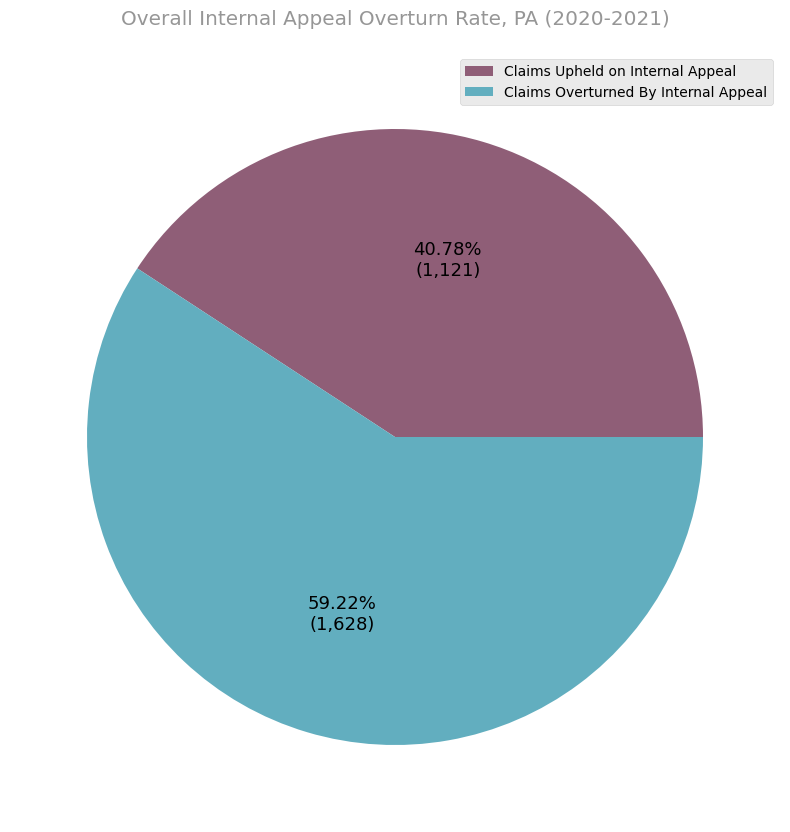

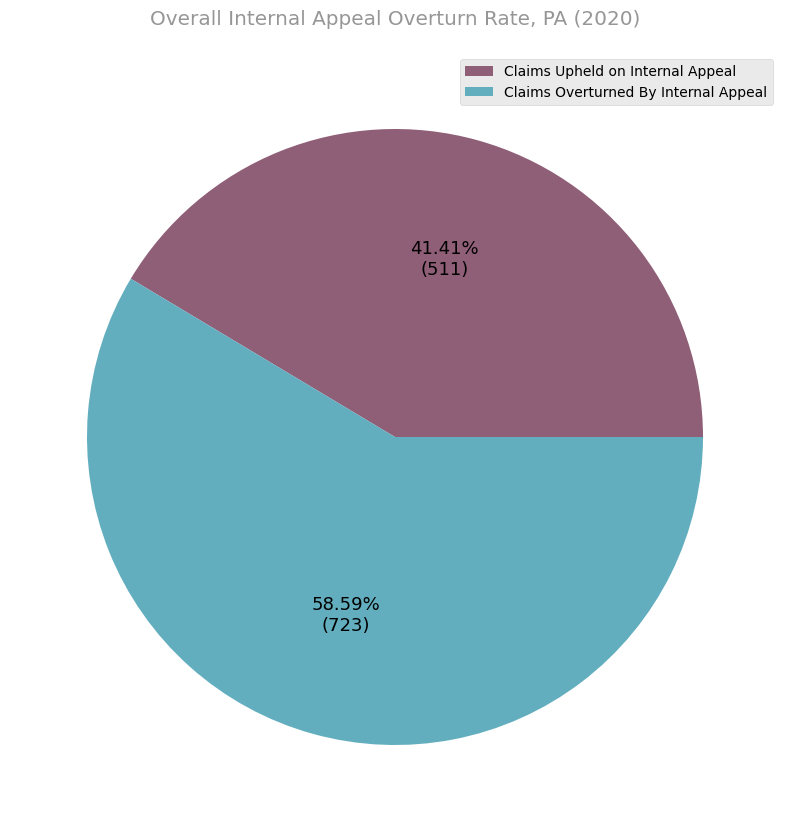

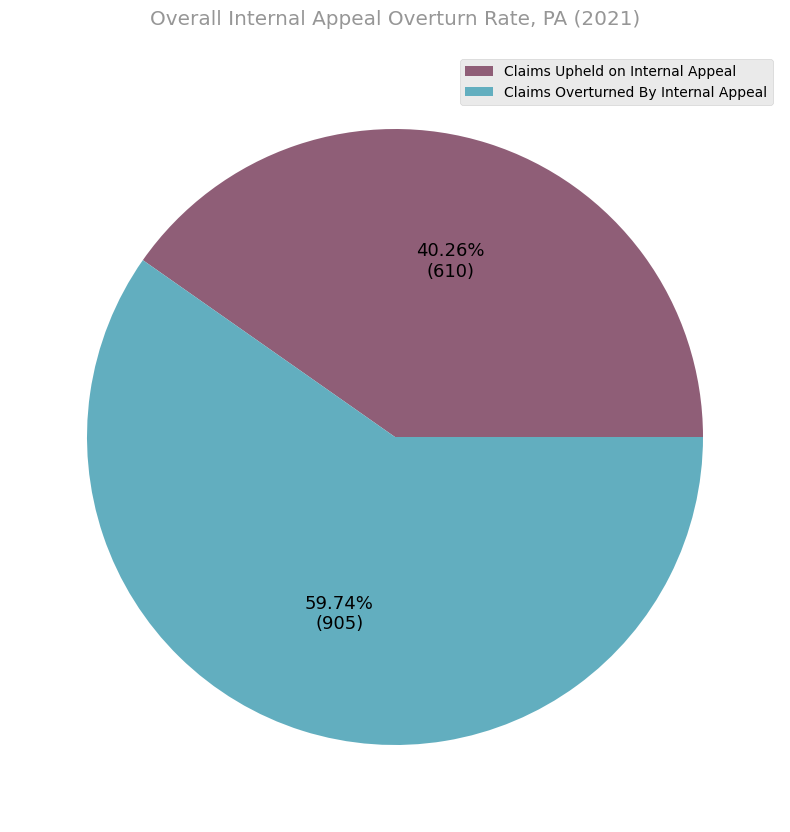

In [16]:
# Internal Appeal Overturn Rate
total_appealed = issuer_df["internal_appeals"].sum()
total_overturned = issuer_df["internal_appeal_overturns"].sum()
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned By Internal Appeal",
    ],
    slice_vals=[total_appealed - total_overturned, total_overturned],
    title="Overall Internal Appeal Overturn Rate, PA (2020-2021)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_overturns_pie.png"),
)


issuer_2020 = year_dfs[0]
total_appealed = issuer_2020["internal_appeals"].sum()
total_overturned = issuer_2020["internal_appeal_overturns"].sum()
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned By Internal Appeal",
    ],
    slice_vals=[total_appealed - total_overturned, total_overturned],
    title="Overall Internal Appeal Overturn Rate, PA (2020)"
    if not NO_PLOT_TITLES
    else None,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_overturns_pie_2020.png"),
)


issuer_2021 = year_dfs[1]
total_appealed = issuer_2021["internal_appeals"].sum()
total_overturned = issuer_2021["internal_appeal_overturns"].sum()
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned By Internal Appeal",
    ],
    slice_vals=[total_appealed - total_overturned, total_overturned],
    title="Overall Internal Appeal Overturn Rate, PA (2021)",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_overturns_pie_2021.png"),
)

In [17]:
issuer_df.head()

,hios_id,insurer_name,data_plan_year,current_plan_year,sadp_only,claims_received,claims_denied,internal_appeals,internal_appeal_overturns,external_appeals,external_appeal_overturns,denial_rate,internal_appeal_rate,internal_appeal_success_rate,external_appeal_rate,external_appeal_success_rate
0,16322,UPMC Health Options,2021,2023,False,5177242.0,238250.0,115.0,15.0,11.0,1.0,0.046019,0.000483,0.130435,0.110000,0.090909
1,22444,Geisinger Health Plan,2020,2022,False,716789.0,107049.0,113.0,58.0,0.0,0.0,0.149345,0.001056,0.513274,0.000000,NaN
2,31609,QCC,2021,2023,False,2226728.0,388219.0,232.0,129.0,15.0,2.0,0.174345,0.000598,0.556034,0.145631,0.133333
3,33709,Highmark,2021,2023,False,1697634.0,206788.0,319.0,169.0,2.0,0.0,0.121810,0.001543,0.529781,0.013333,0.000000
4,33871,KHPE,2020,2022,False,7225828.0,1422909.0,545.0,285.0,36.0,11.0,0.196920,0.000383,0.522936,0.138462,0.305556


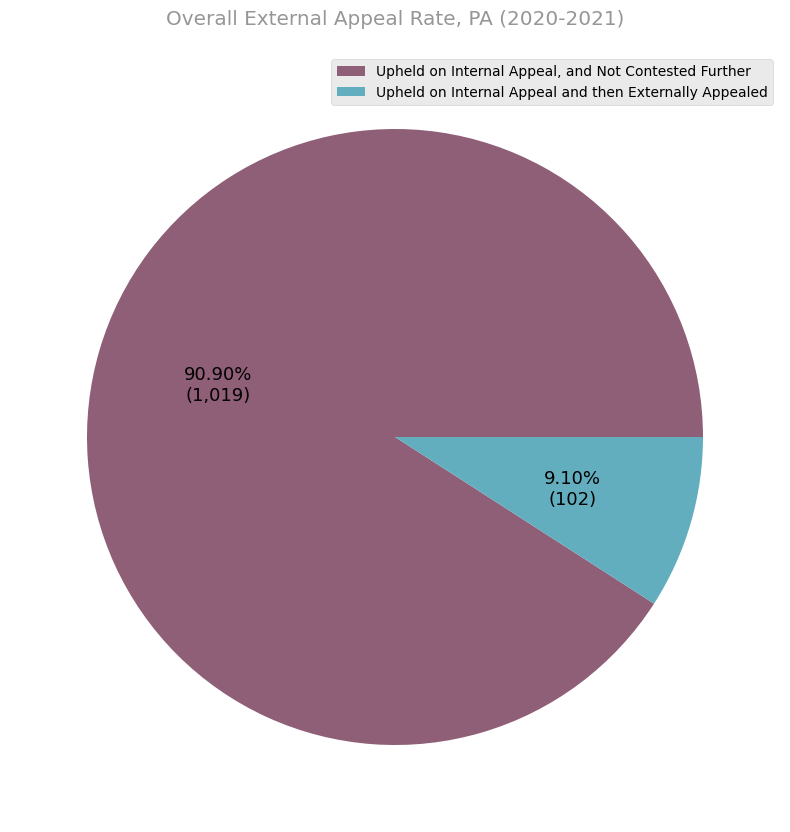

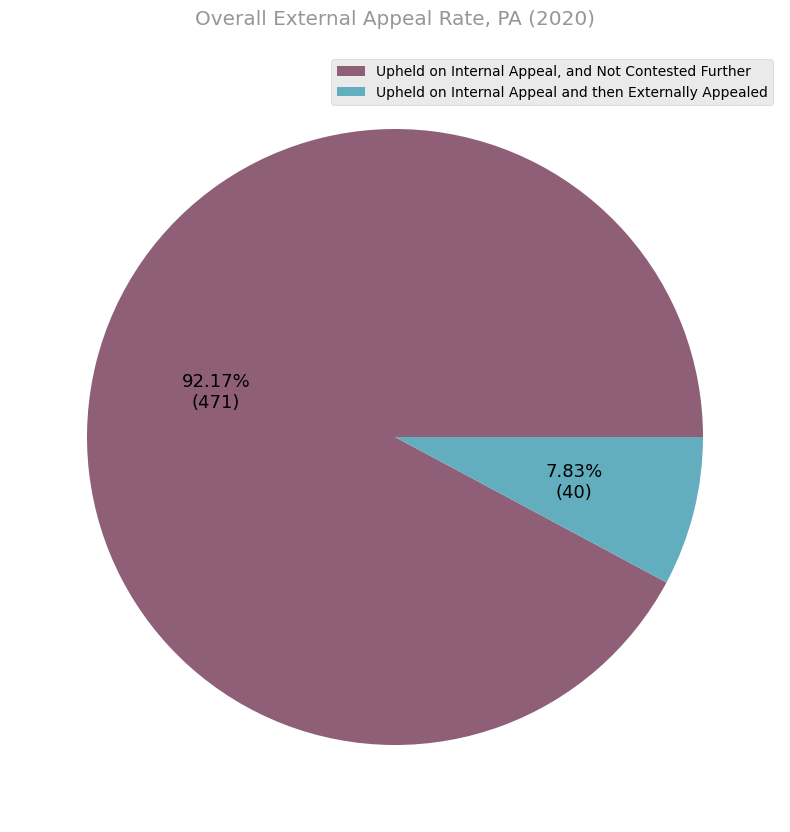

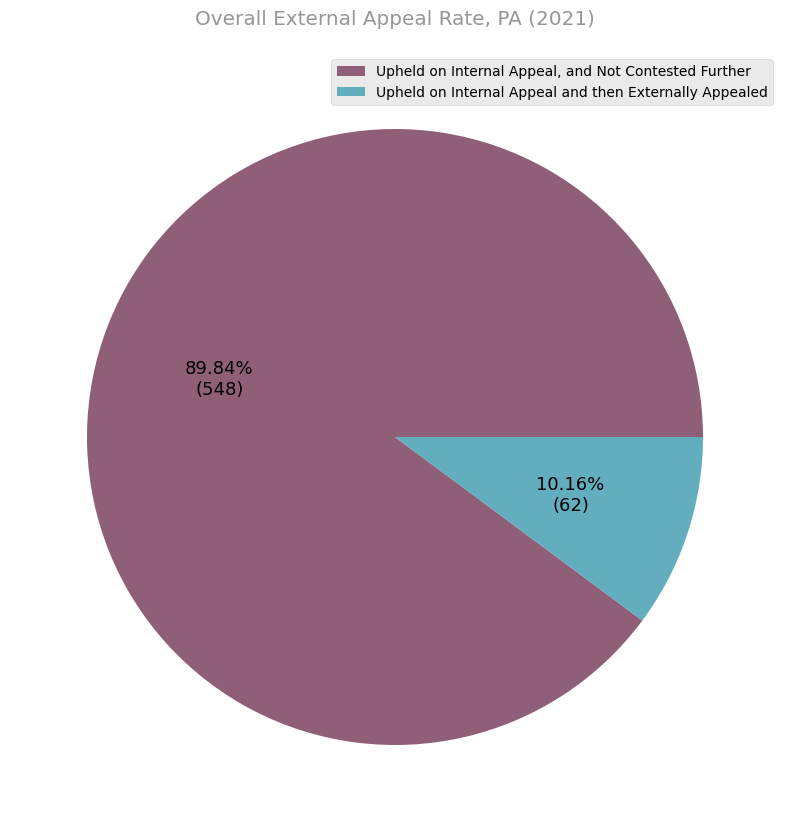

In [18]:
# External Appeal Rate
claims_externally_appealed = issuer_df["external_appeals"].sum()
claims_upheld = (
    issuer_df["internal_appeals"].sum() - issuer_df["internal_appeal_overturns"].sum()
)
plot_pie(
    slice_names=[
        "Upheld on Internal Appeal, and Not Contested Further",
        "Upheld on Internal Appeal and then Externally Appealed",
    ],
    slice_vals=[claims_upheld - claims_externally_appealed, claims_externally_appealed],
    title="Overall External Appeal Rate, PA (2020-2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_external_appeal_rate_pie.png"),
    show=True,
)

issuer_2020 = year_dfs[0]
claims_externally_appealed = issuer_2020["external_appeals"].sum()
claims_upheld = (
    issuer_2020["internal_appeals"].sum()
    - issuer_2020["internal_appeal_overturns"].sum()
)
plot_pie(
    slice_names=[
        "Upheld on Internal Appeal, and Not Contested Further",
        "Upheld on Internal Appeal and then Externally Appealed",
    ],
    slice_vals=[claims_upheld - claims_externally_appealed, claims_externally_appealed],
    title="Overall External Appeal Rate, PA (2020)" if not NO_PLOT_TITLES else None,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overall_external_appeal_rate_pie_2020.png"
    ),
    show=True,
)

issuer_2021 = year_dfs[1]
claims_externally_appealed = issuer_2021["external_appeals"].sum()
claims_upheld = (
    issuer_2021["internal_appeals"].sum()
    - issuer_2021["internal_appeal_overturns"].sum()
)
plot_pie(
    slice_names=[
        "Upheld on Internal Appeal, and Not Contested Further",
        "Upheld on Internal Appeal and then Externally Appealed",
    ],
    slice_vals=[claims_upheld - claims_externally_appealed, claims_externally_appealed],
    title="Overall External Appeal Rate, PA (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overall_external_appeal_rate_pie_2021.png"
    ),
    show=True,
)

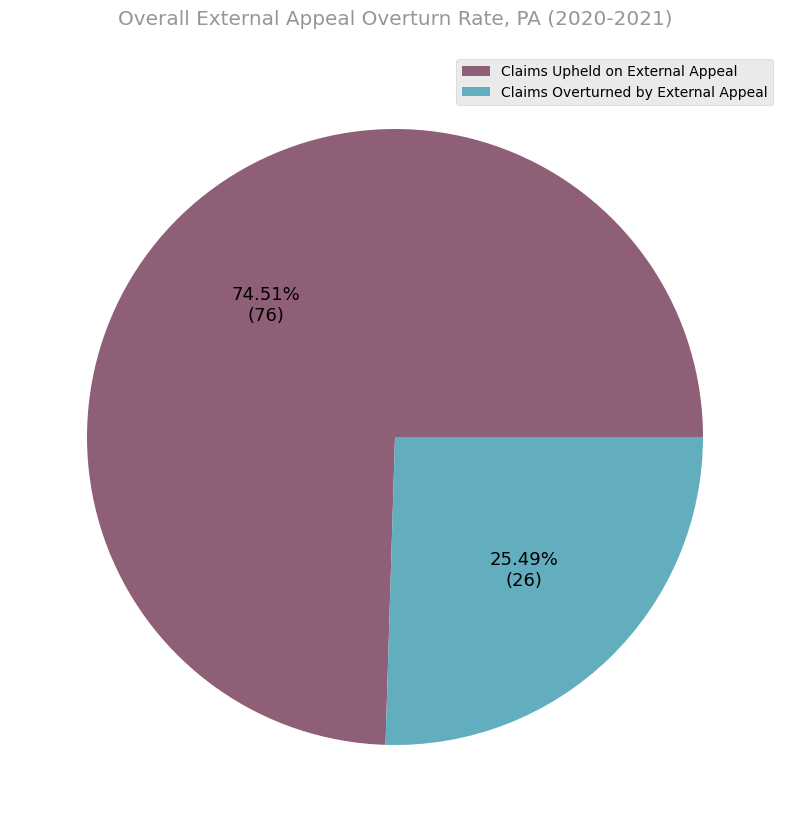

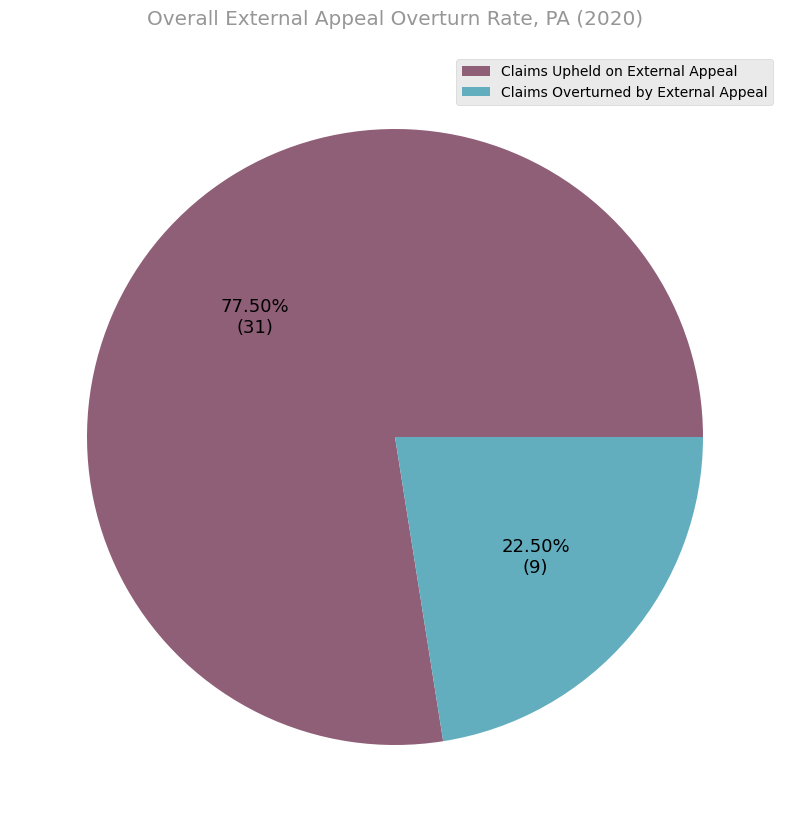

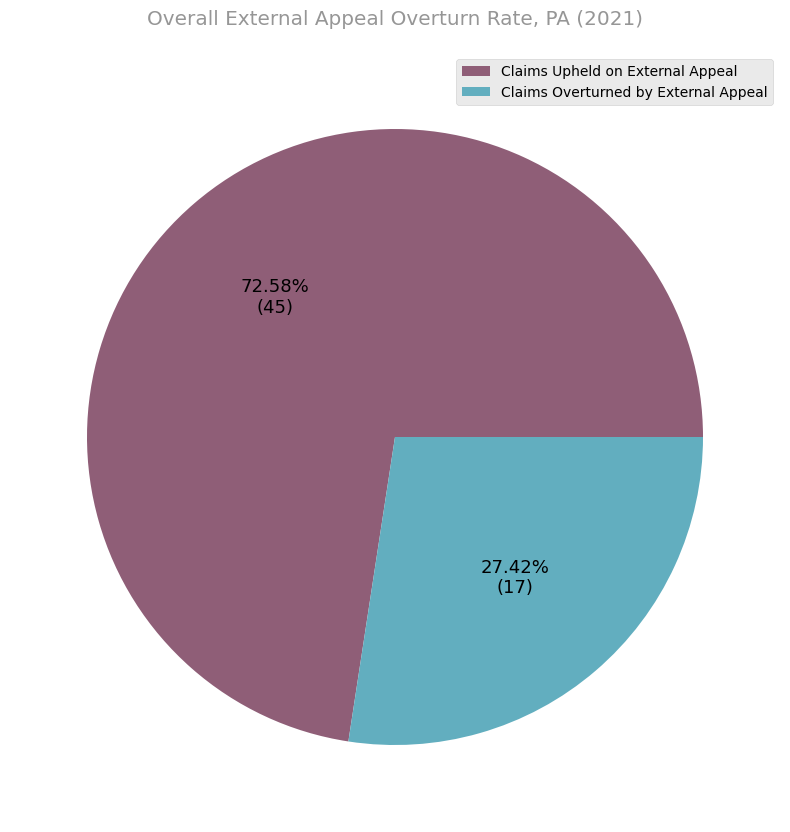

In [19]:
# External Appeal Overturn Rate
claims_externally_appealed = issuer_df["external_appeals"].sum()
claims_externally_overturned = issuer_df["external_appeal_overturns"].sum()
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="Overall External Appeal Overturn Rate, PA (2020-2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

issuer_2020 = year_dfs[0]
claims_externally_appealed = issuer_2020["external_appeals"].sum()
claims_externally_overturned = issuer_2020["external_appeal_overturns"].sum()
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="Overall External Appeal Overturn Rate, PA (2020)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates_2020.png"),
    show=True,
)

issuer_2021 = year_dfs[1]
claims_externally_appealed = issuer_2021["external_appeals"].sum()
claims_externally_overturned = issuer_2021["external_appeal_overturns"].sum()
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="Overall External Appeal Overturn Rate, PA (2021)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates_2021.png"),
    show=True,
)

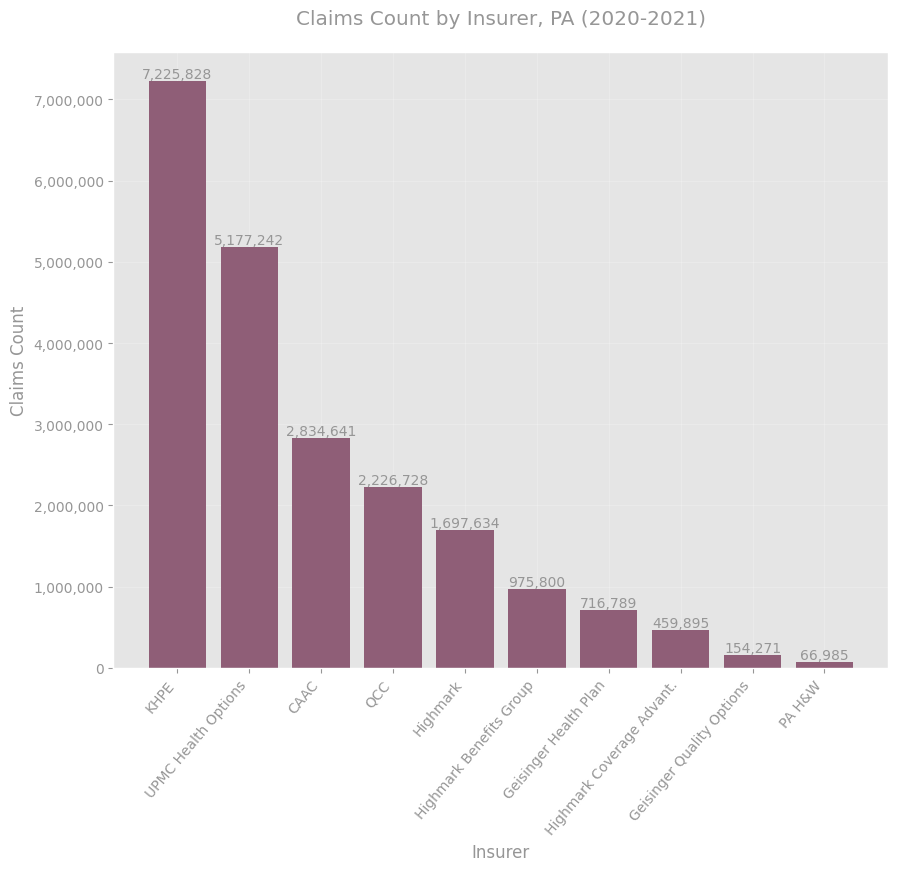

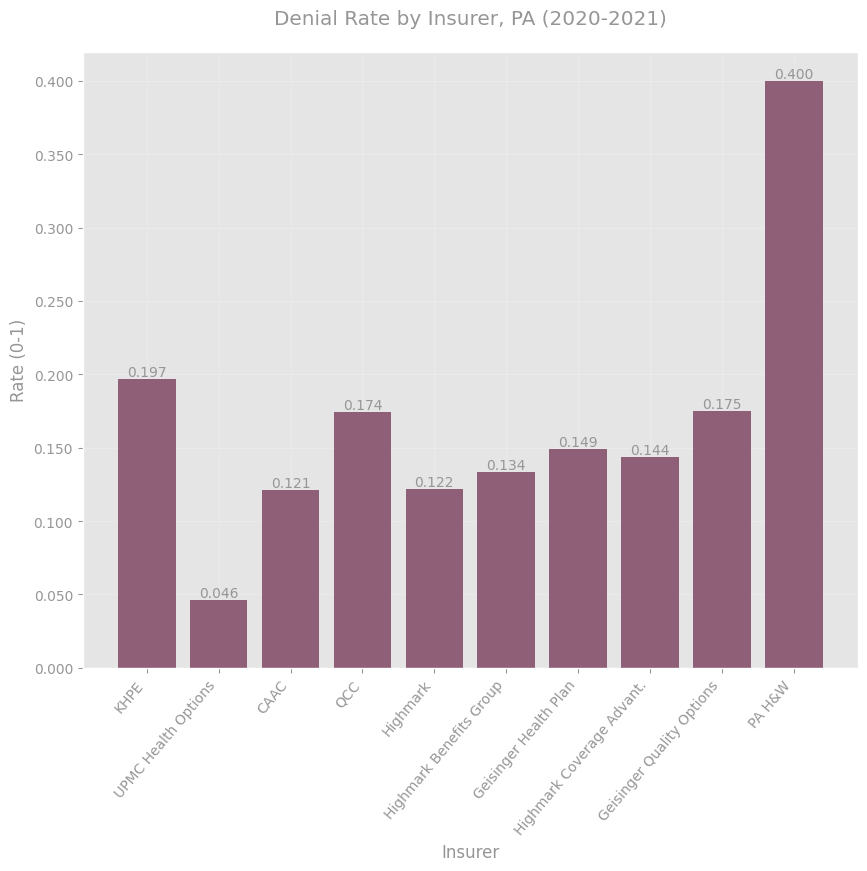

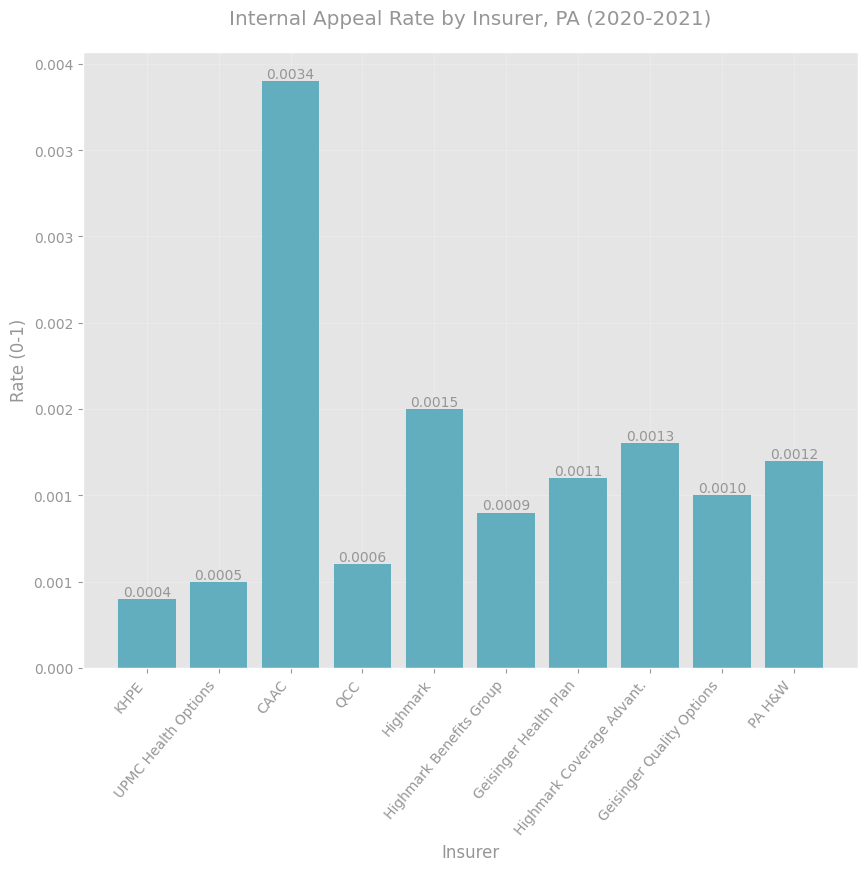

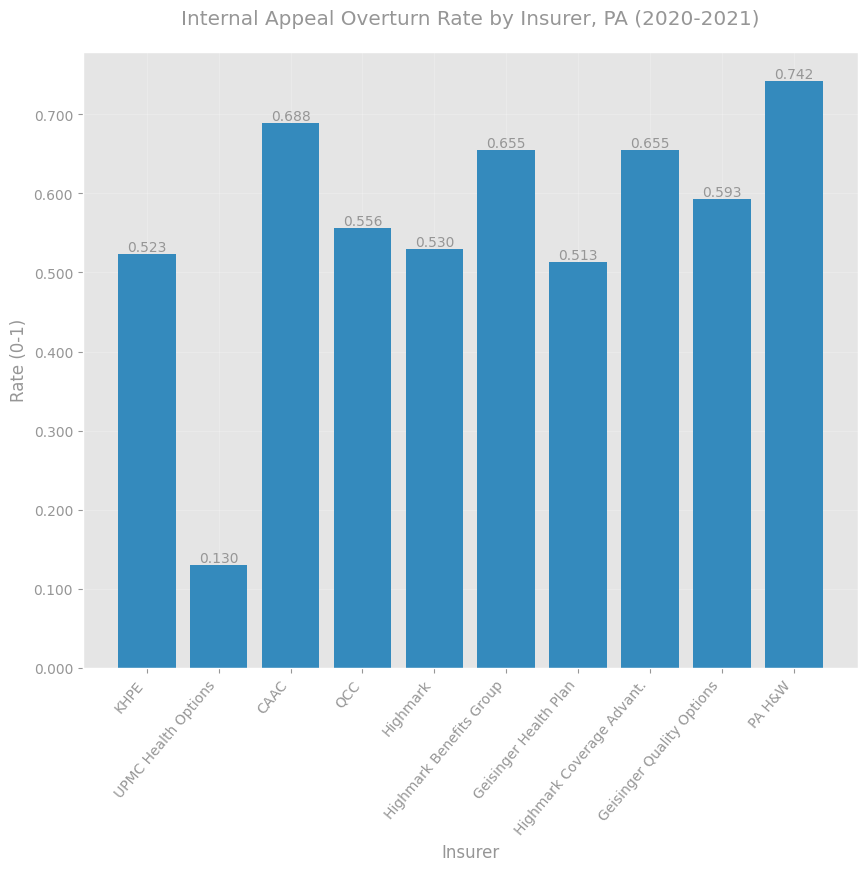

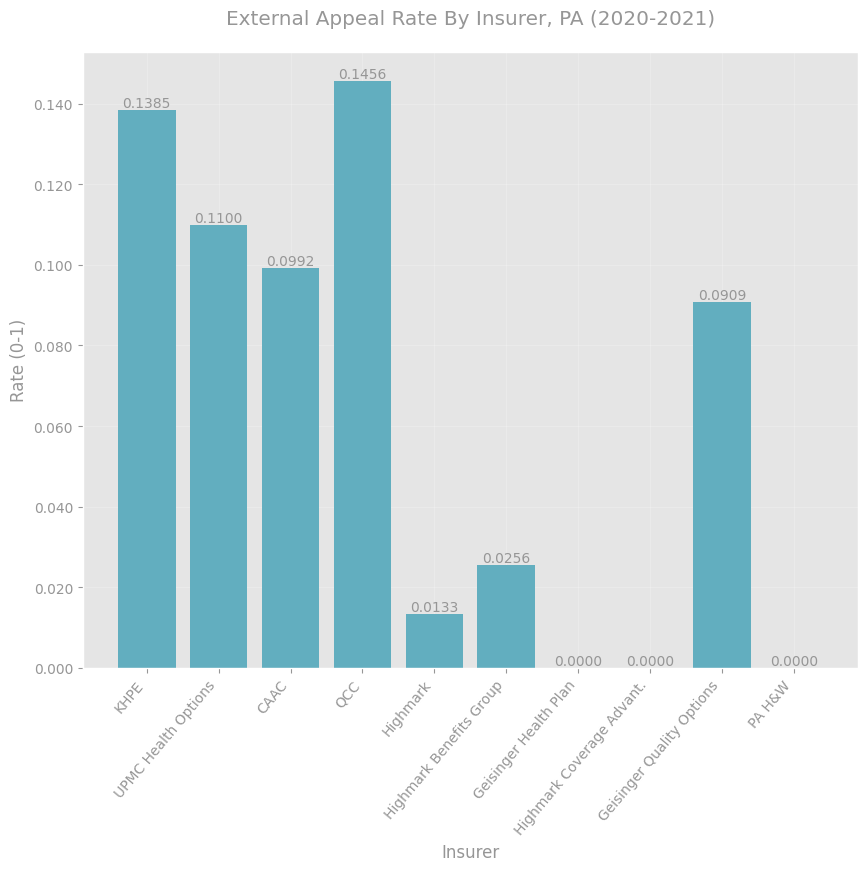

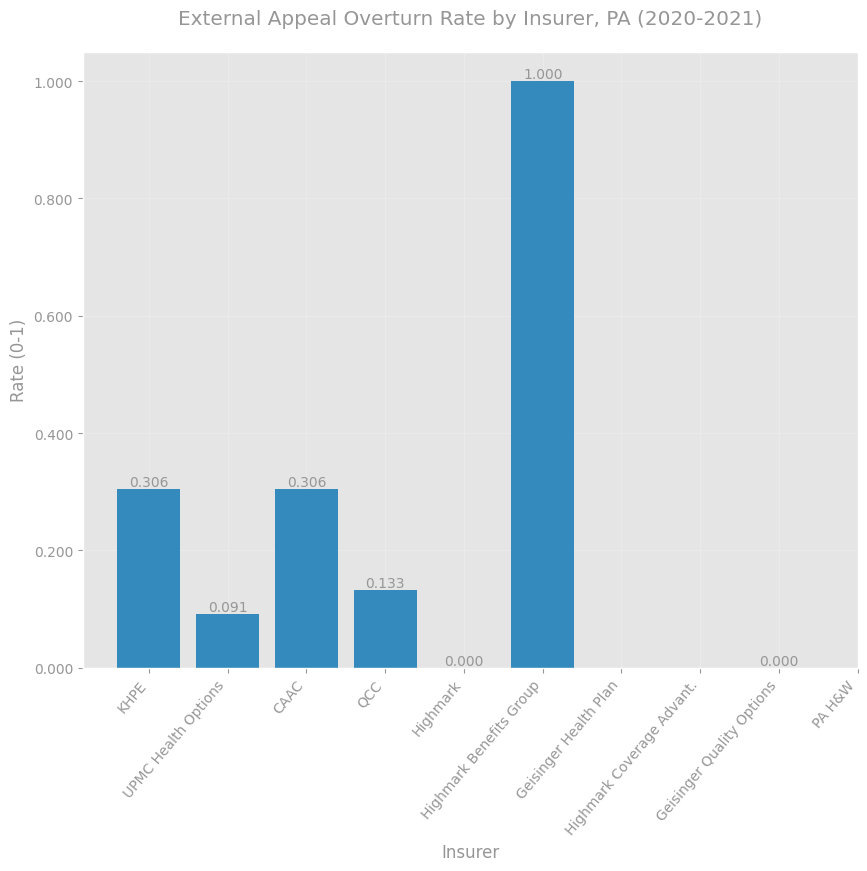

In [20]:
# Plot denial rates, appeal rates, success rates by insurer (aggregate)
k = 10
year = "2020-2021"
top_k = issuer_df.sort_values(by="claims_received", ascending=False)[:k]

bar_names = top_k["insurer_name"].values
bar_vals = [round(x, 6) for x in top_k["claims_received"].values]
val_axis_label = "Claims Count"
cat_axis_label = "Insurer"
title = f"Claims Count by Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "claims_by_insurer.png"),
    bar_label=True,
    int_vals=True,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)


bar_names = top_k["insurer_name"].values
bar_vals = [round(x, 6) for x in top_k["denial_rate"].values]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = f"Denial Rate by Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)

bar_vals = [round(x, 4) for x in top_k["internal_appeal_rate"].values]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = f"Internal Appeal Rate by Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"appeal_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=SECONDARY_HEX,
    float_precision_depth=4,
    figsize=(10, 8),
)

bar_vals = [round(x, 6) for x in top_k["internal_appeal_success_rate"].values]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = f"Internal Appeal Overturn Rate by Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"internal_appeal_overturn_rate_by_insurer.png"
    ),
    bar_label=True,
    int_vals=False,
    color_hex=TERTIARY_HEX,
    figsize=(10, 8),
)

bar_vals = [round(x, 4) for x in top_k["external_appeal_rate"].values]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = f"External Appeal Rate By Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"external_appeal_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=SECONDARY_HEX,
    float_precision_depth=4,
    figsize=(10, 8),
)

bar_vals = [round(x, 6) for x in top_k["external_appeal_success_rate"].values]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = f"External Appeal Overturn Rate by Insurer, PA ({year})"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, f"external_appeal_overturn_rate_by_insurer_{year}.png"
    ),
    bar_label=True,
    int_vals=False,
    color_hex=TERTIARY_HEX,
    figsize=(10, 8),
)

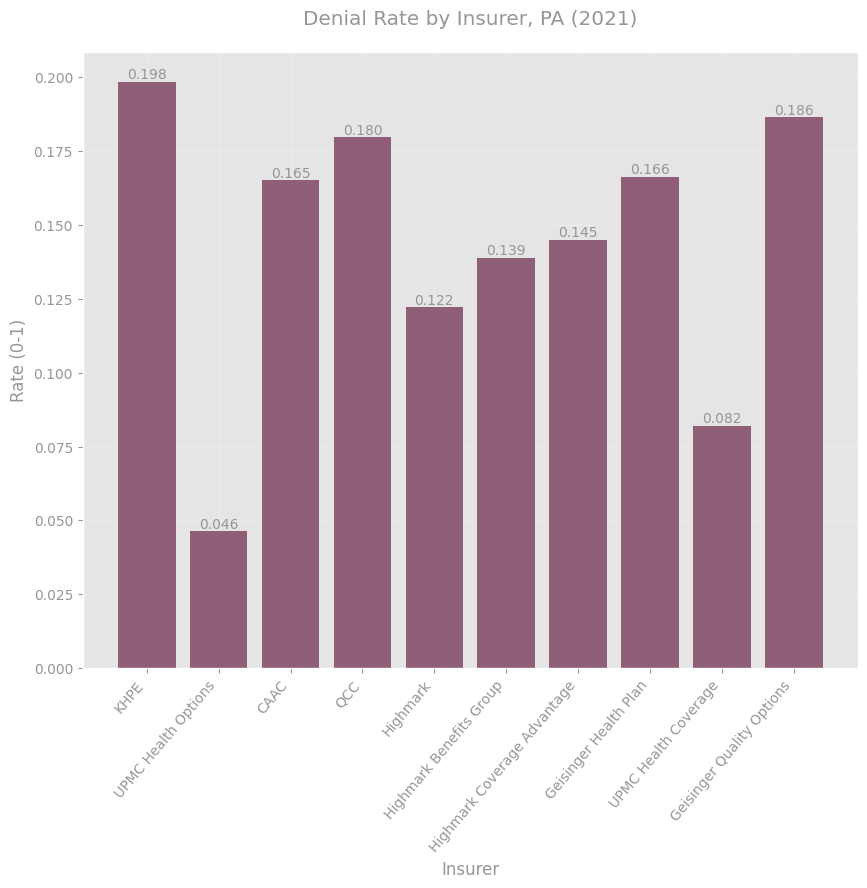

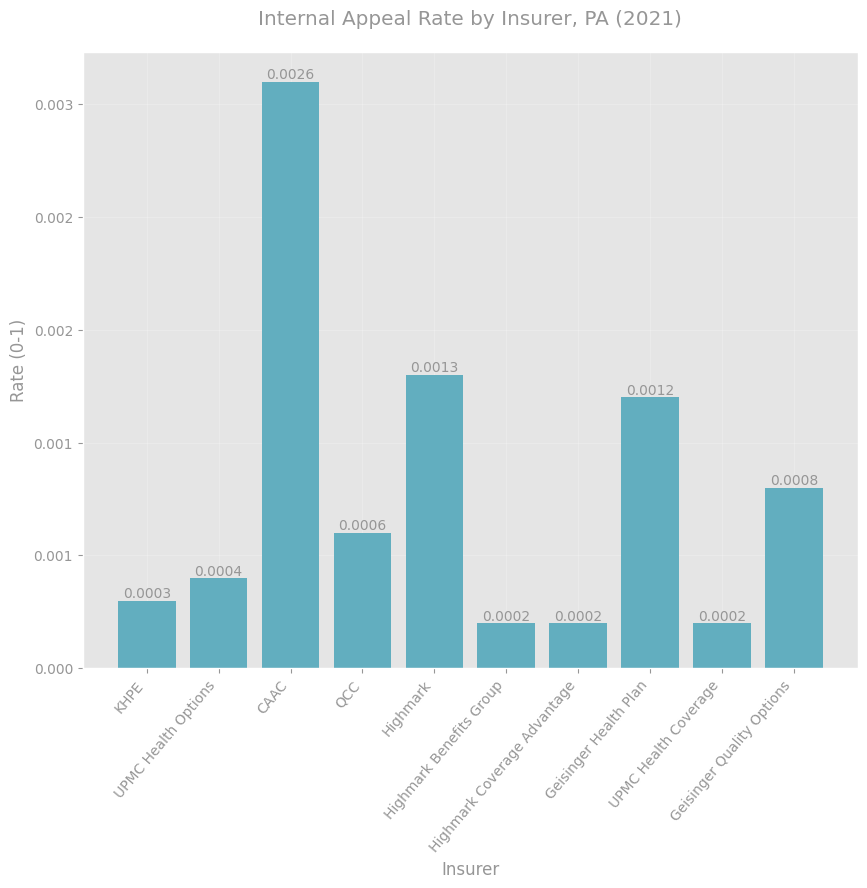

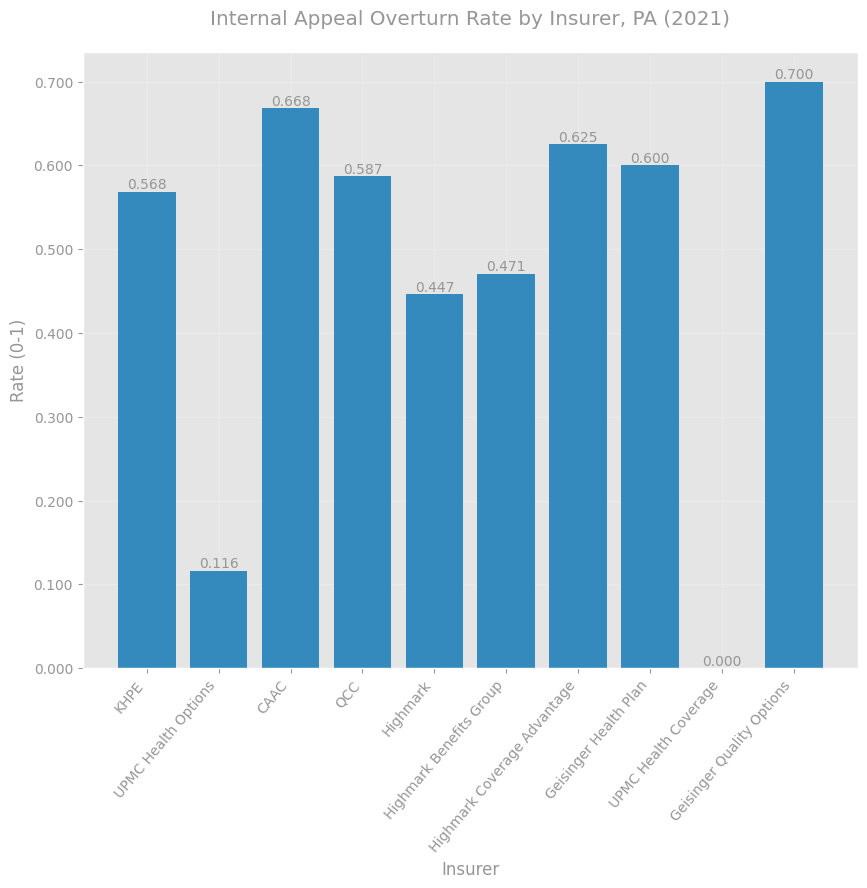

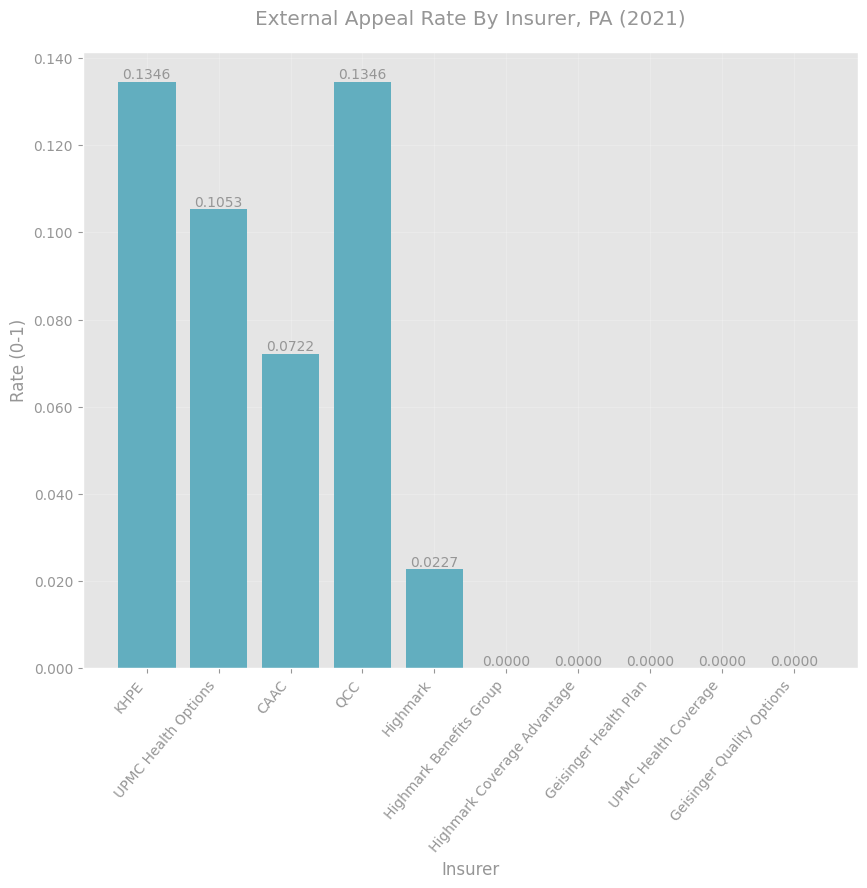

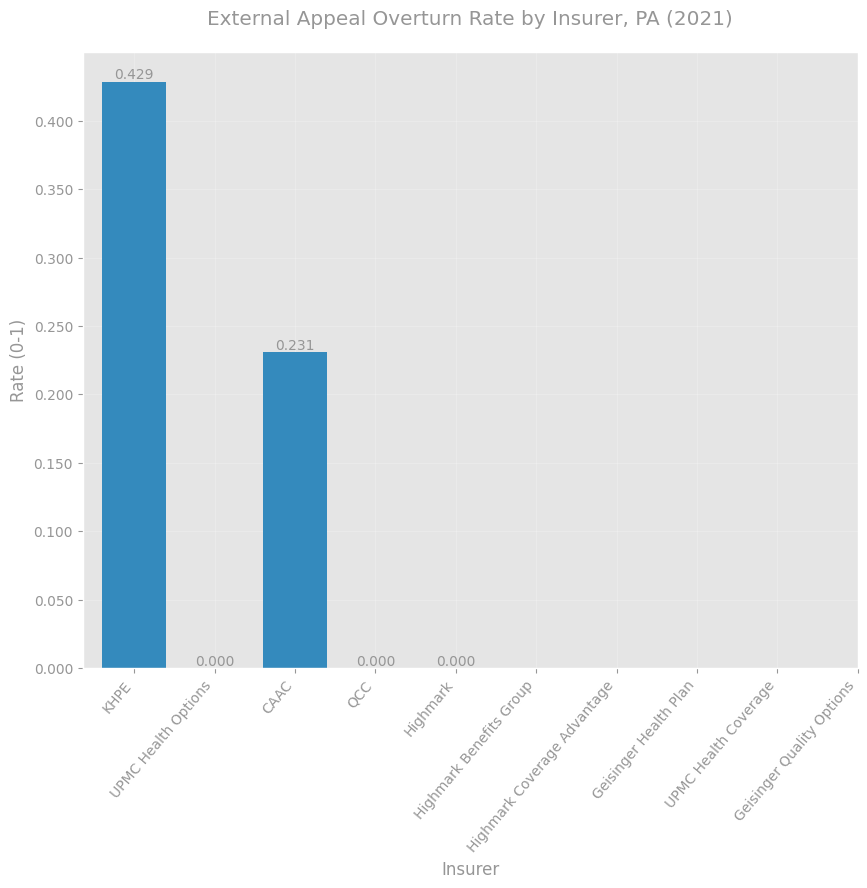

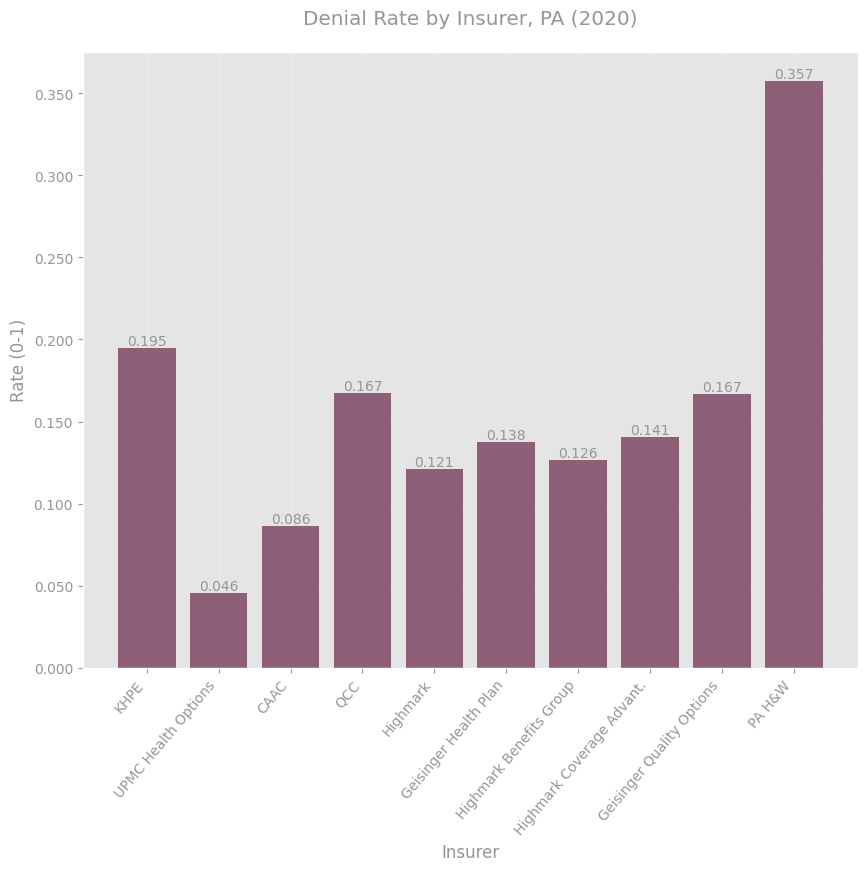

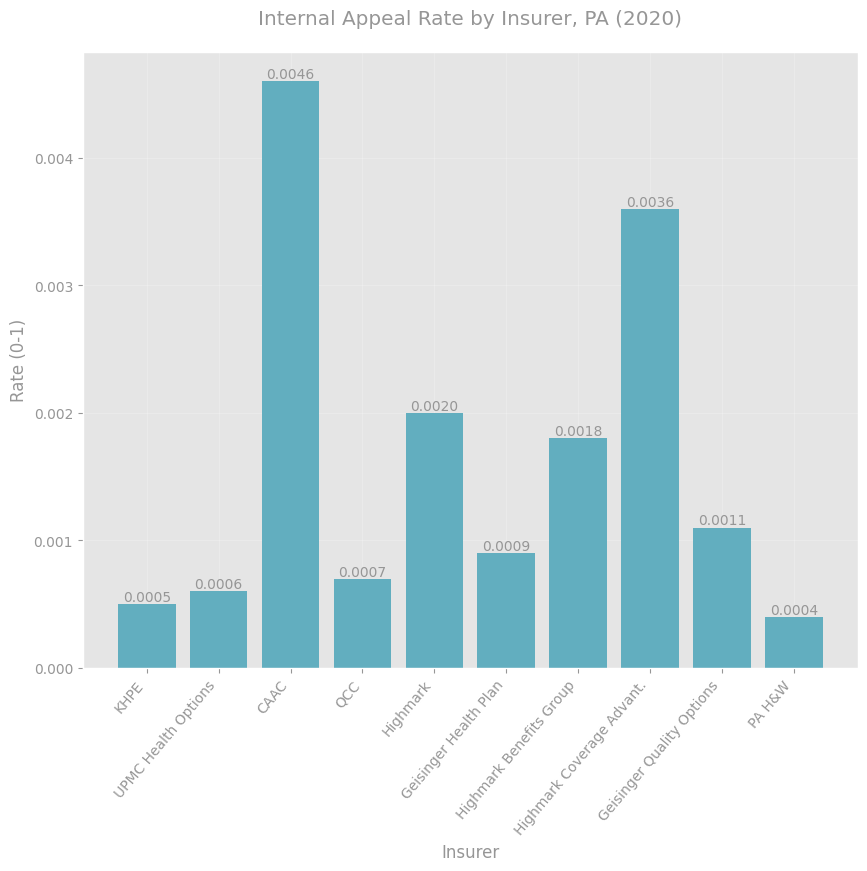

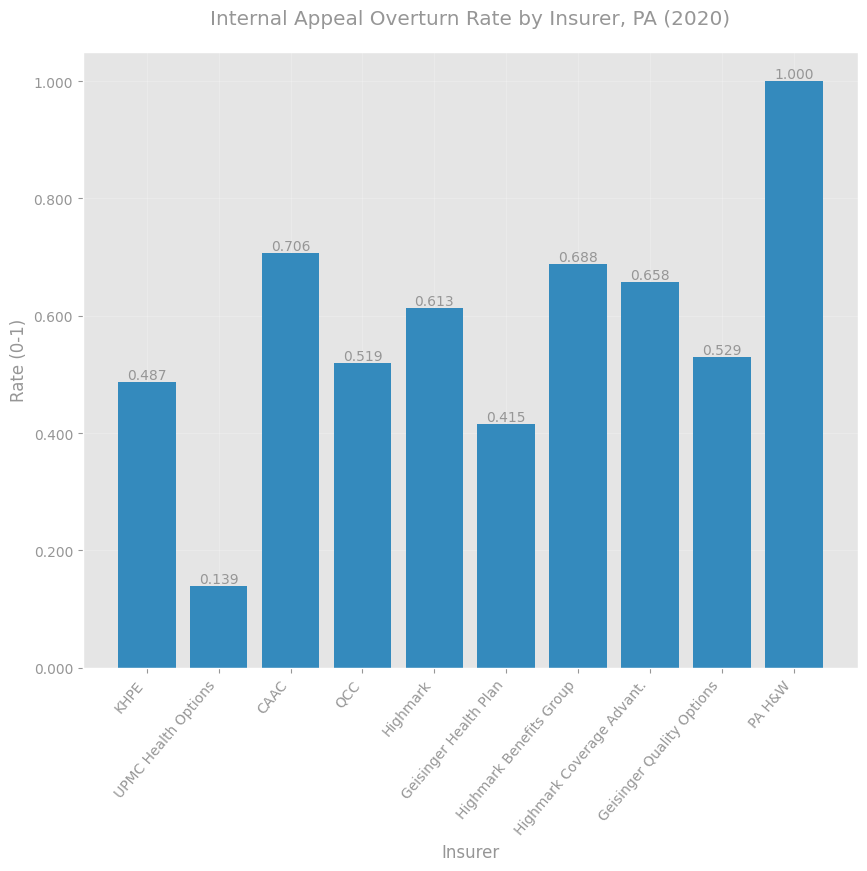

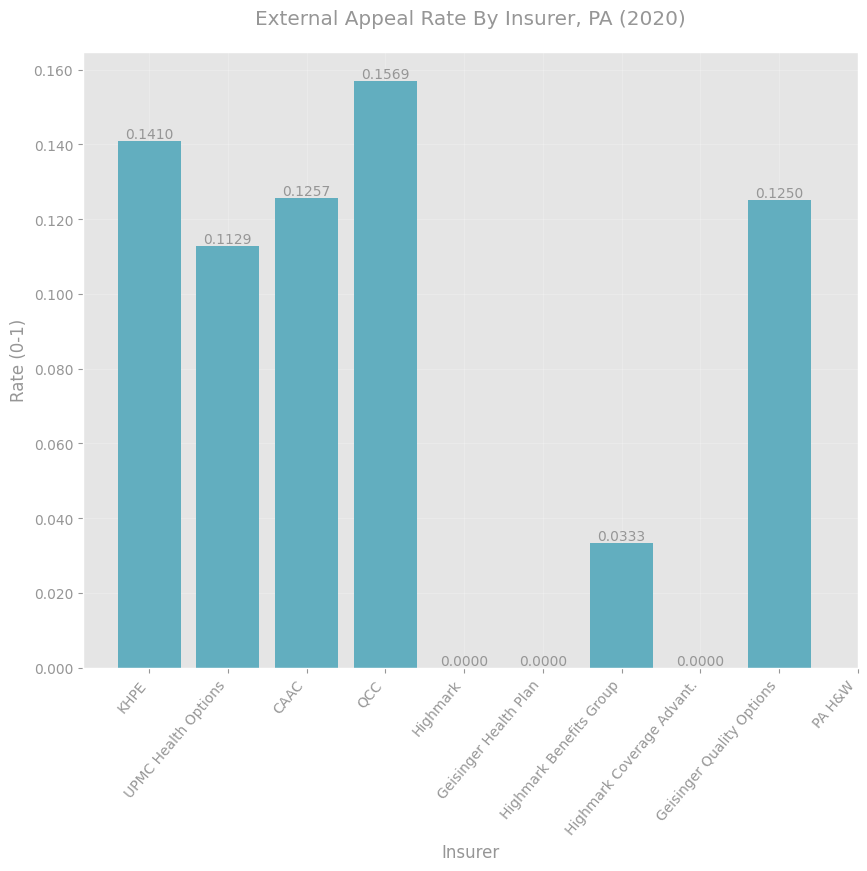

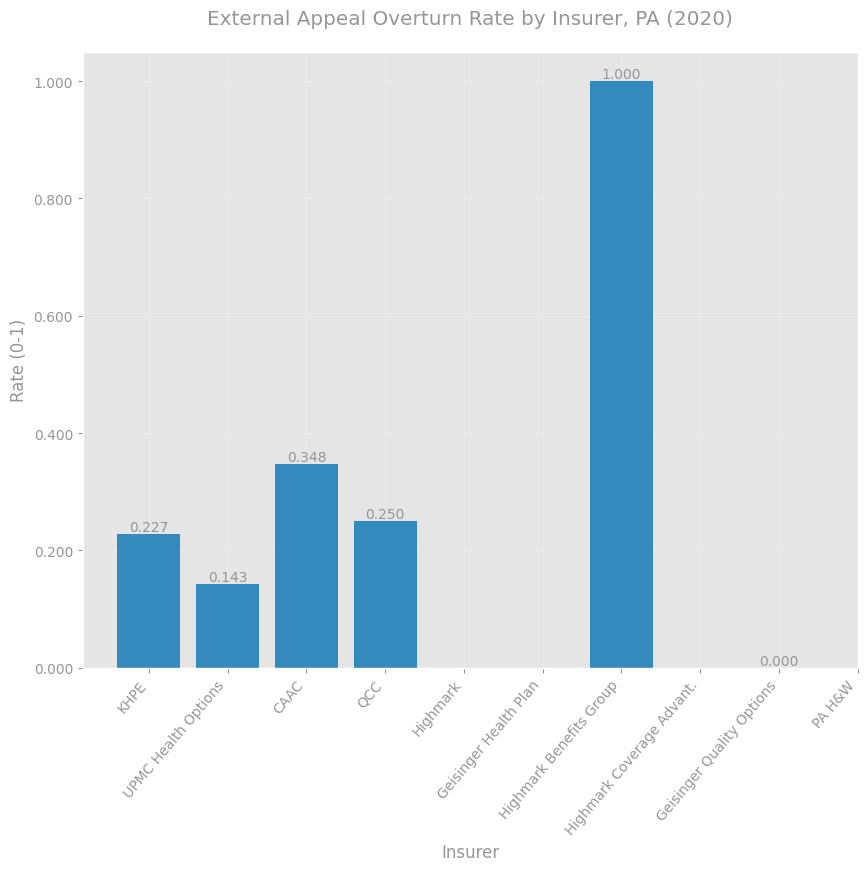

In [21]:
# Plot denial rates, appeal rates, success rates by insurer, by year
k = 10
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    top_k = year_df.sort_values(by="claims_received", ascending=False)[:k]
    bar_names = top_k["insurer_name"].values
    bar_vals = [round(x, 6) for x in top_k["denial_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Denial Rate by Insurer, PA ({year})"
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rate_by_insurer_{year}.png"),
        bar_label=True,
        int_vals=False,
        color_hex=PRIMARY_HEX,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 4) for x in top_k["internal_appeal_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Internal Appeal Rate by Insurer, PA ({year})"
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"appeal_rate_by_insurer_{year}.png"),
        bar_label=True,
        int_vals=False,
        color_hex=SECONDARY_HEX,
        float_precision_depth=4,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 6) for x in top_k["internal_appeal_success_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Internal Appeal Overturn Rate by Insurer, PA ({year})"
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"internal_appeal_overturn_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=TERTIARY_HEX,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 4) for x in top_k["external_appeal_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"External Appeal Rate By Insurer, PA ({year})"
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeal_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=SECONDARY_HEX,
        float_precision_depth=4,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 6) for x in top_k["external_appeal_success_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"External Appeal Overturn Rate by Insurer, PA ({year})"
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeal_overturn_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=TERTIARY_HEX,
        figsize=(10, 8),
    )

## Marketplace Plan Data

In [22]:
# Throw out plan records with too few claims
MIN_CLAIMS = 100
plan_df = plan_df[plan_df["claims_received"] >= MIN_CLAIMS]

In [23]:
# verify denial rationales sum correctly
# Doesn't hold, presumably because they allow multiple rationales per claim,
# though even this doesn't hold for all records, as the below assertion shows
assert (
    plan_df["claims_denied"]
    <= (
        plan_df["claims_denied_prior_auth_referral"]
        + plan_df["claims_denied_oon_provider"]
        + plan_df["claims_denied_exclusion_of_service"]
        + plan_df["claims_denied_nmn_excl_behavioral"]
        + plan_df["claims_denied_nmn_behavioral"]
        + plan_df["claims_denied_other"]
    )
).all(), "Sum of denial rationales is not always greater than or equal to denial count."

AssertionError: Sum of denial rationales is not always greater than or equal to denial count.

In [24]:
def get_overall_plan_rates(plan_df: pd.DataFrame):
    # Add relevant plan level rates
    # Note: this data is marketplace plans only
    df = plan_df
    df["denial_rate"] = df["claims_denied"] / df["claims_received"]
    df["nmn_denials"] = (
        df["claims_denied_nmn_excl_behavioral"] + df["claims_denied_nmn_behavioral"]
    )
    df["nmn_denial_rate"] = df["nmn_denials"] / df["claims_received"]

    # Compute totals across marketplace plans
    plan_claims_received = df["claims_received"].sum()
    plan_denials = df["claims_denied"].sum()
    plan_nmn_denials = df["nmn_denials"].sum()

    overall_denial_rate = plan_denials / plan_claims_received
    overall_nmn_denial_rate = plan_nmn_denials / plan_claims_received

    print(f"\tOverall denial rate: {overall_denial_rate:.2}")
    print(f"\tOverall NMN denial rate: {overall_nmn_denial_rate:.2}")
    return df


def get_overall_plan_rates_by_year(plan_df: pd.DataFrame, data_year: int) -> tuple:
    """Get aggregate denial and appeal rates across issuers, from the plan df."""
    df = plan_df[plan_df["data_plan_year"] == data_year].copy(deep=True)

    df = get_overall_plan_rates(df)
    return df

In [25]:
year_dfs = []
for year in plan_df["data_plan_year"].unique():
    print(f"{year} plan data:")
    year_df = get_overall_plan_rates_by_year(plan_df, year)
    year_dfs.append(year_df)

2021 plan data:
	Overall denial rate: 0.14
	Overall NMN denial rate: 0.01
2020 plan data:
	Overall denial rate: 0.12
	Overall NMN denial rate: 0.007


In [26]:
print("Combined:\n")
plan_df = get_overall_plan_rates(
    plan_df.groupby(["hios_issuer_id", "plan_id"], as_index=False).sum()
)

Combined:

	Overall denial rate: 0.13
	Overall NMN denial rate: 0.0085


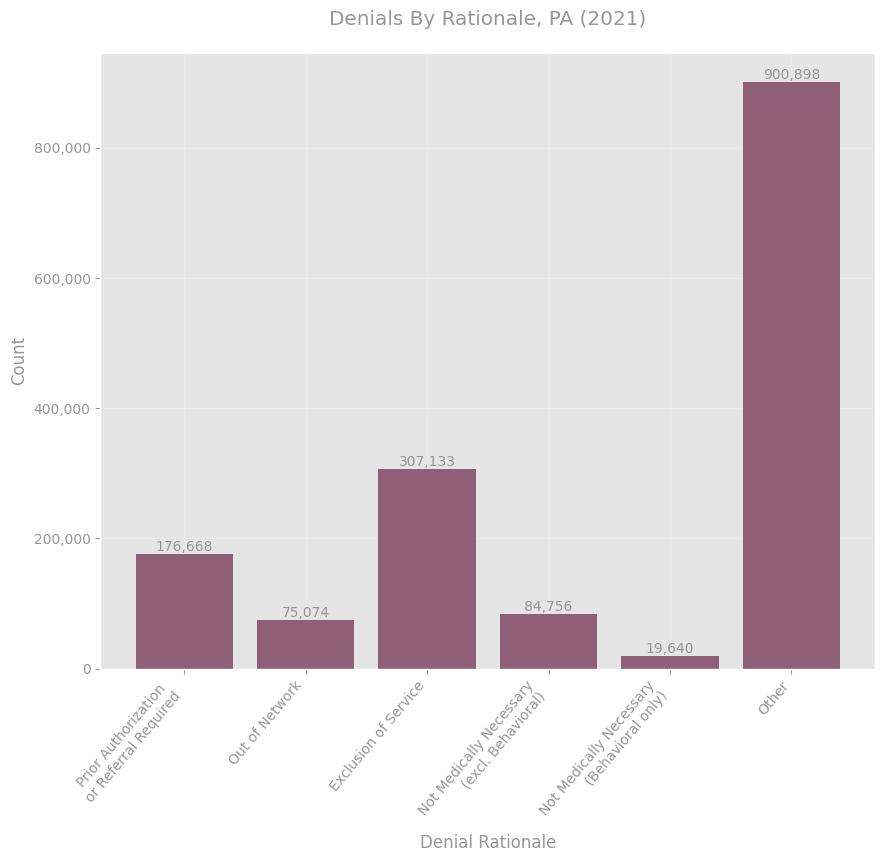

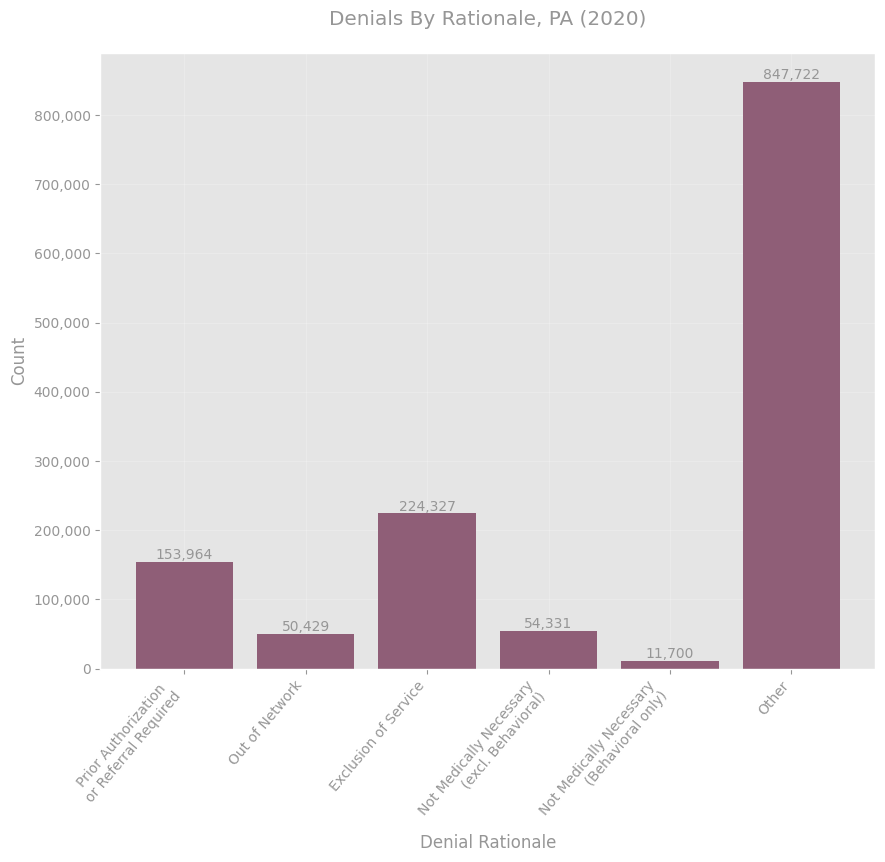

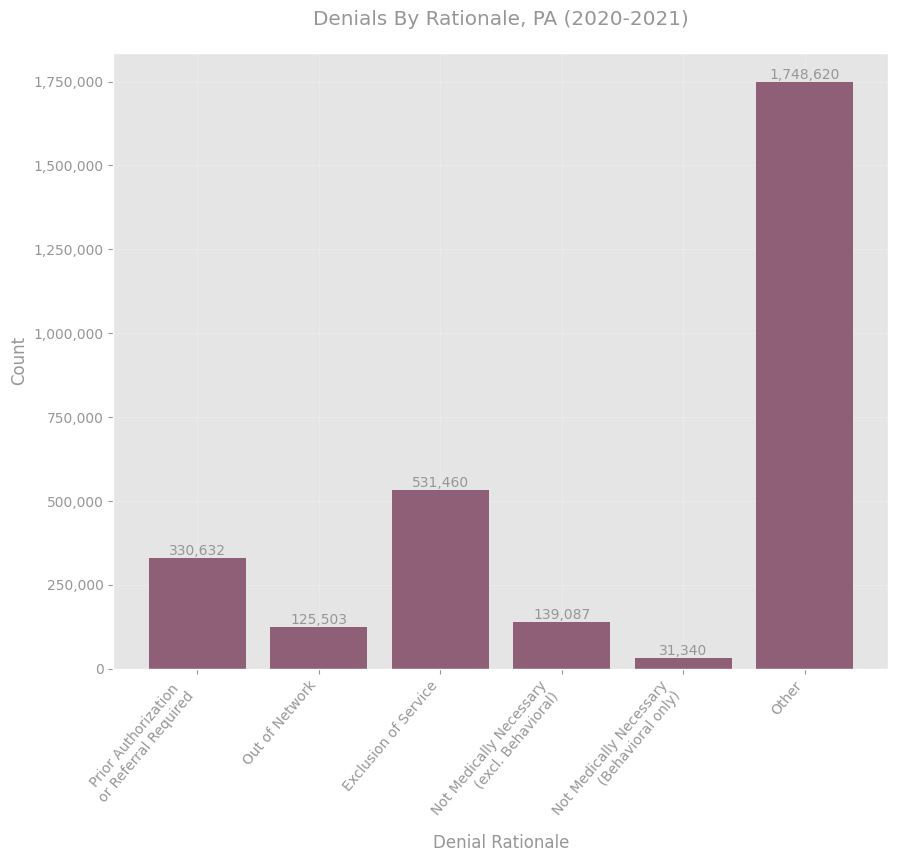

In [27]:
# Plot denial rationale breakdown across all plans, by year
rationale_cat_map = {
    "claims_denied_prior_auth_referral": "Prior Authorization \nor Referral Required",
    "claims_denied_oon_provider": "Out of Network",
    "claims_denied_exclusion_of_service": "Exclusion of Service",
    "claims_denied_nmn_excl_behavioral": "Not Medically Necessary\n (excl. Behavioral)",
    "claims_denied_nmn_behavioral": "Not Medically Necessary\n (Behavioral only)",
    "claims_denied_other": "Other",
}

for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    bar_vals = [year_df[col].sum() for col in rationale_cat_map.keys()]
    bar_names = list(rationale_cat_map.values())
    title = f"Denials By Rationale, PA ({year})"
    val_axis_label = "Count"
    cat_axis_label = "Denial Rationale"

    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        bar_label=True,
        figsize=(10, 8),
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rationale_dist_{year}.png"),
    )

# Aggregate plot
year = "2020-2021"
bar_vals = [plan_df[col].sum() for col in rationale_cat_map.keys()]
bar_names = list(rationale_cat_map.values())
title = f"Denials By Rationale, PA ({year})"
val_axis_label = "Count"
cat_axis_label = "Denial Rationale"

plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    figsize=(10, 8),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rationale_dist_{year}.png"),
)

In [28]:
# Heatmap of denial rate types by insurer
denial_type_cats = rationale_cat_map.keys()
bar_names = rationale_cat_map.values()
insurers_col = "insurer_name"
total_denials_col = "claims_denied"
insurer_list = list(top_k["insurer_name"])

arr = np.zeros((len(insurer_list), len(denial_type_cats)))
for idx, row in top_k.iterrows():
    try:
        row_idx = insurer_list.index(row[insurers_col])
        for col_idx, col in enumerate(denial_type_cats):
            denial_frac = row[col] / row[total_denials_col]
            arr[row_idx, col_idx] = denial_frac
    except ValueError as e:
        pass

fig, ax = plt.subplots(figsize=(10, 10))
if not NO_PLOT_TITLES:
    plt.title("Denial Rationales by Insurer, PA (2020-2021)")

heat_val_name = f"Fraction of Insurer Denials"
im, cbar = heatmap(
    arr,
    insurer_list,
    bar_names,
    ax=ax,
    cmap=PRIMARY_CMAP,
    cbarlabel=heat_val_name,
    cbar_kw={"shrink": 0.3},
)

fig.tight_layout()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "insurer_vs_denial_cat.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

KeyError: 'claims_denied_prior_auth_referral'

In [ ]:
# NMN denial rates
for idx, year in enumerate(["2020", "2021"]):
    claims_received = year_dfs[idx]["claims_received"].sum()
    nmn_denials = (
        year_dfs[idx]["claims_denied_nmn_excl_behavioral"].sum()
        + year_dfs[idx]["claims_denied_nmn_behavioral"].sum()
    )
    print(f"Claims received with rationale in {year}: {claims_received}")
    print(f"NMN denials in {year}: {nmn_denials}")
    print(f"NMN denial rate in {year}: {nmn_denials / claims_received}")

Claims received with rationale in 2020: 10451280.0
NMN denials in 2020: 104396.0
NMN denial rate in 2020: 0.009988824335392412
Claims received with rationale in 2021: 9494221.0
NMN denials in 2021: 66031.0
NMN denial rate in 2021: 0.006954862331517246


In [ ]:
# Add Insurer names to plan data
hios_id_to_name = dict(zip(issuer_df["hios_id"], issuer_df["insurer_name"]))
plan_df["insurer_name"] = plan_df["hios_issuer_id"].apply(lambda x: hios_id_to_name[x])

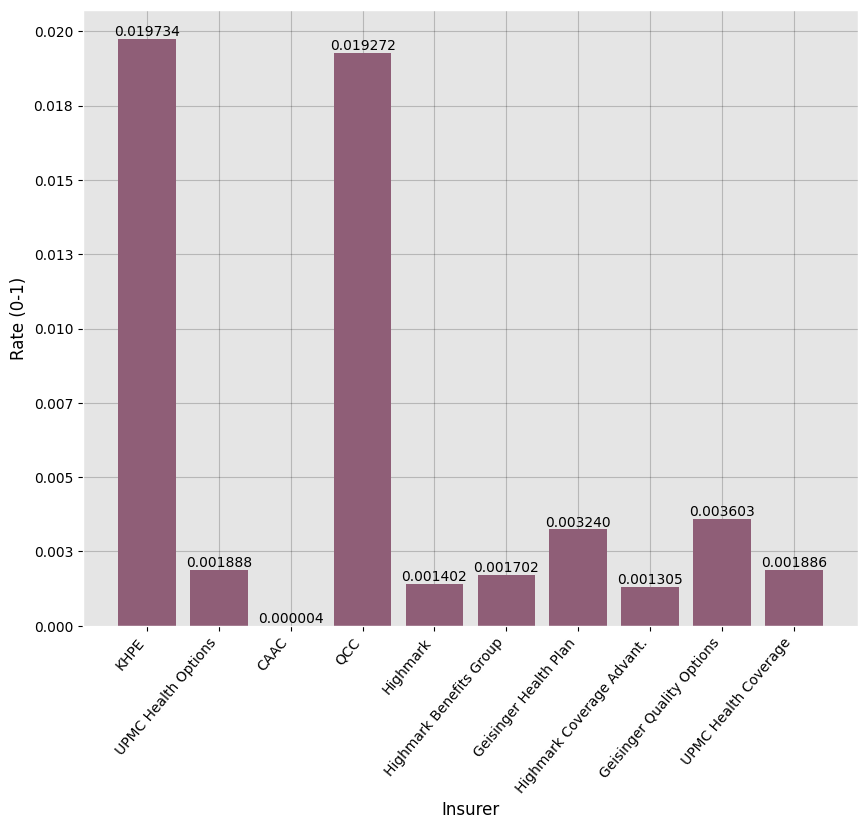

In [ ]:
k = 10
year = "2020-2021"
top_k = (
    plan_df.groupby("insurer_name", as_index=False)
    .sum()
    .sort_values(by="claims_received", ascending=False)[:k]
)

bar_names = top_k["insurer_name"].values
bar_vals = [
    round(x, 6)
    for x in (
        top_k["claims_denied_nmn_excl_behavioral"]
        + top_k["claims_denied_nmn_behavioral"]
    )
    / top_k["claims_received"].values
]

val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "NMN Denial Rate by Insurer, PA (2020-2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
    float_precision_depth=6,
)

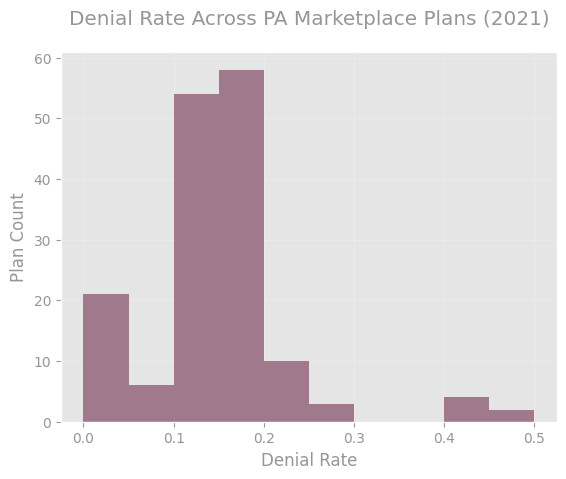

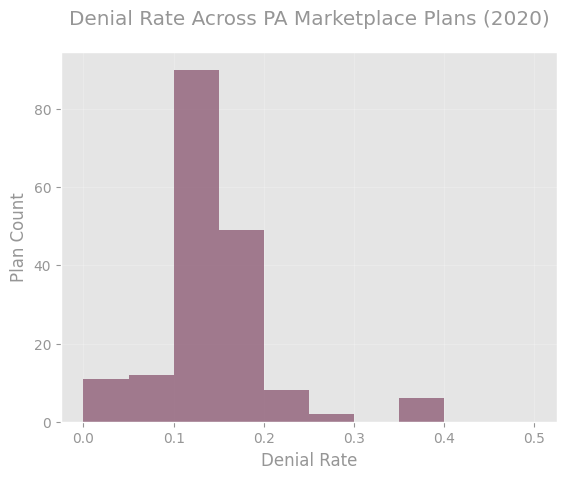

In [29]:
# Denial Rate Distributions Across Plans
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    plot_hist(
        year_df["denial_rate"],
        bins=np.linspace(0, 0.5, 11),
        title=f"Denial Rate Across PA Marketplace Plans ({year})"
        if not NO_PLOT_TITLES
        else None,
        y_label="Plan Count",
        x_label="Denial Rate",
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, "denial_rate_plan_distribution_{year}.png"
        ),
    )

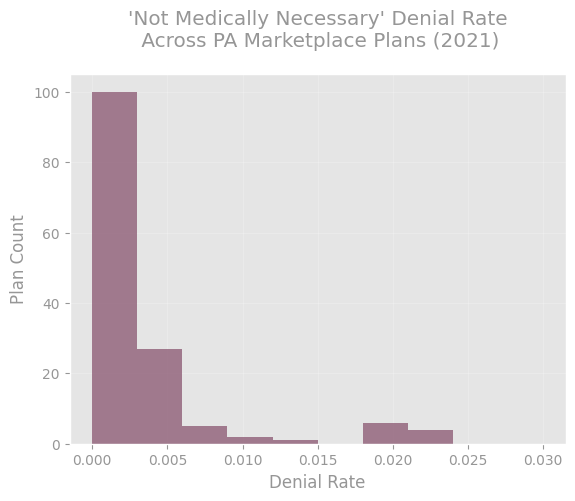

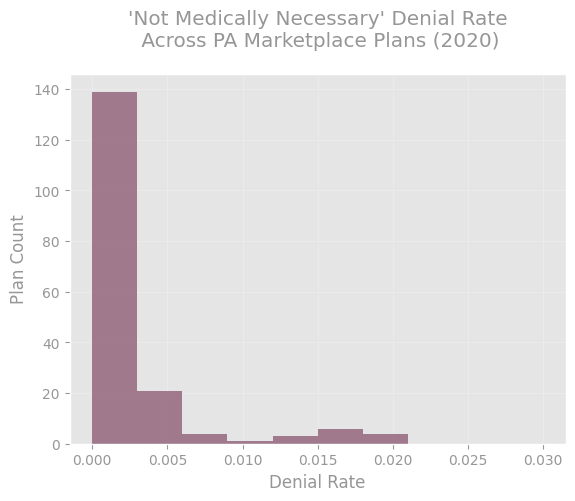

In [30]:
# NMN Denial Rate Distributions Across Plans
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    plot_hist(
        year_df["nmn_denial_rate"],
        bins=np.linspace(0, 0.03, 11),
        title=f"'Not Medically Necessary' Denial Rate\n Across PA Marketplace Plans ({year})"
        if not NO_PLOT_TITLES
        else None,
        y_label="Plan Count",
        x_label="Denial Rate",
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, "nmn_denial_rate_plan_distribution_{year}.png"
        ),
    )

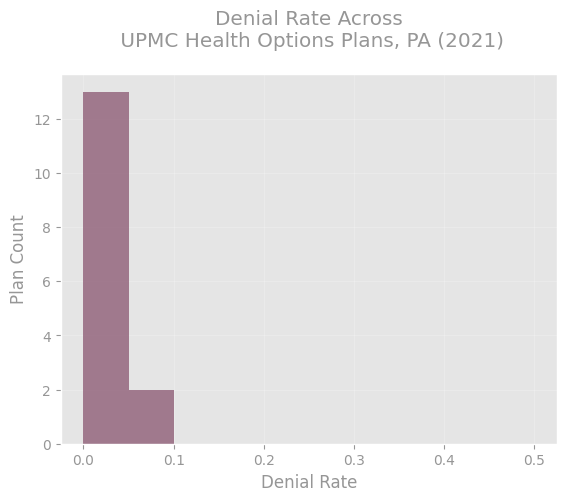

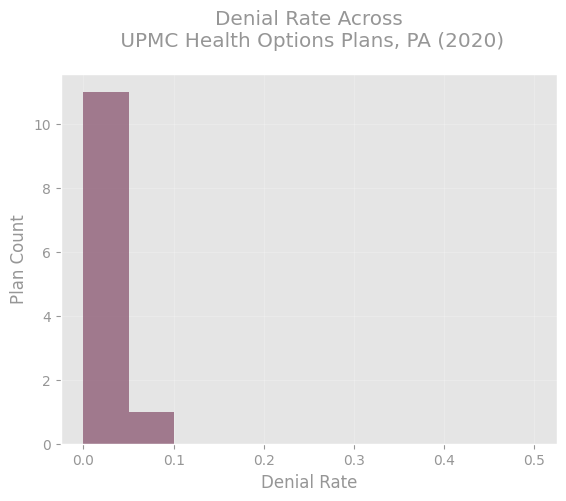

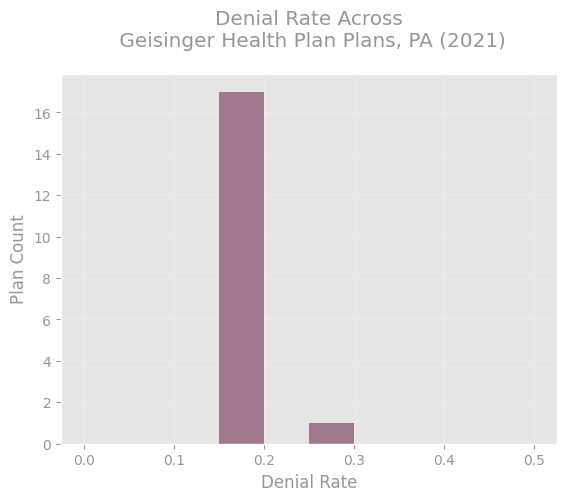

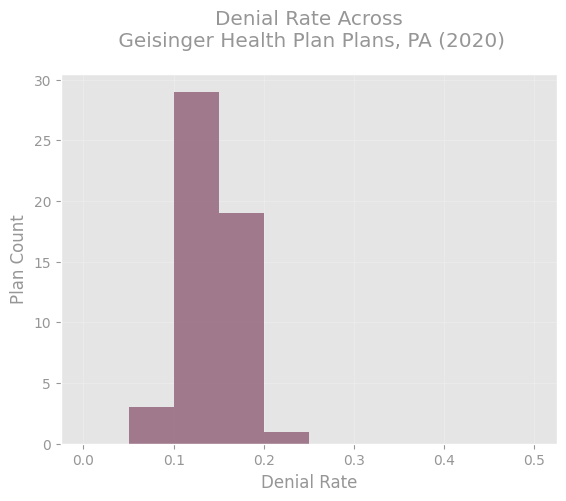

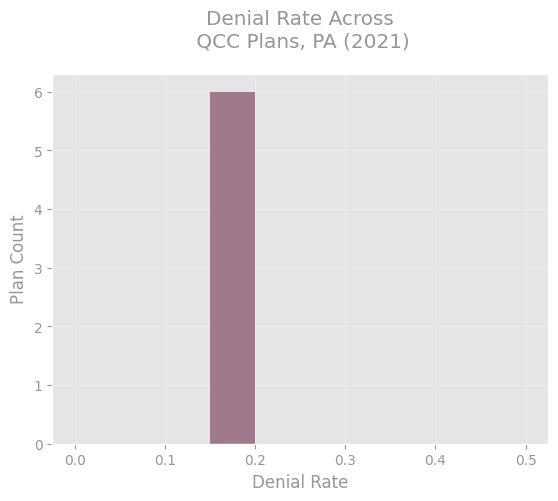

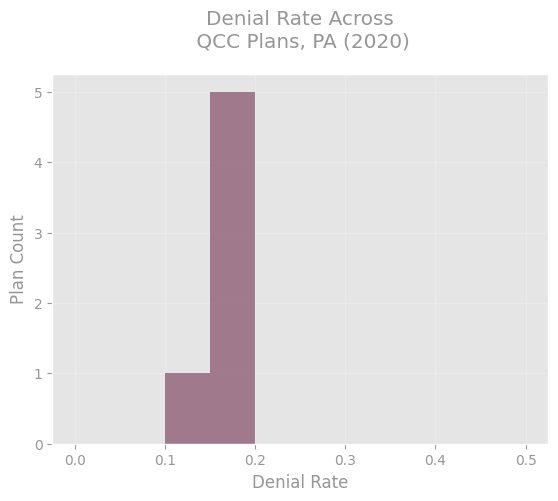

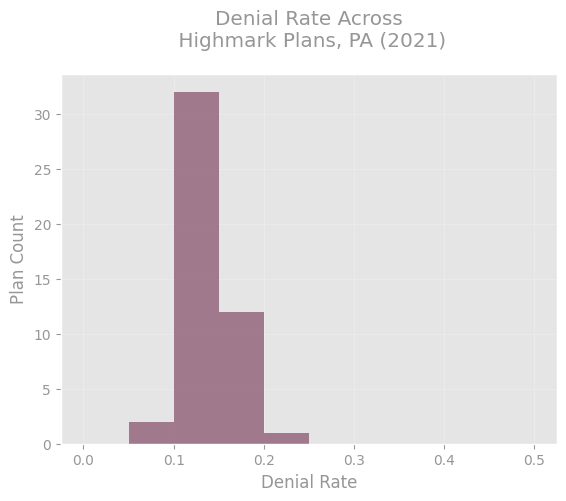

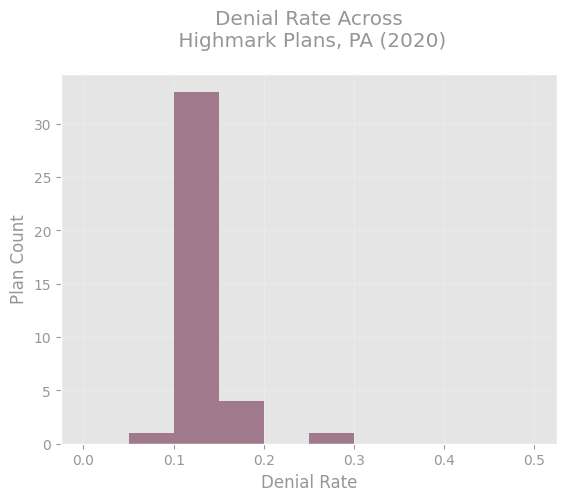

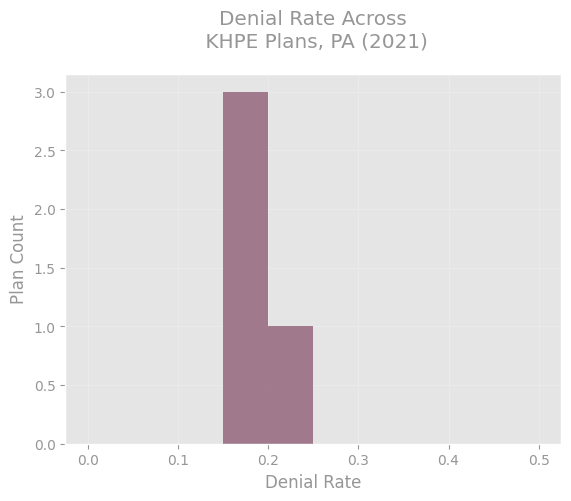

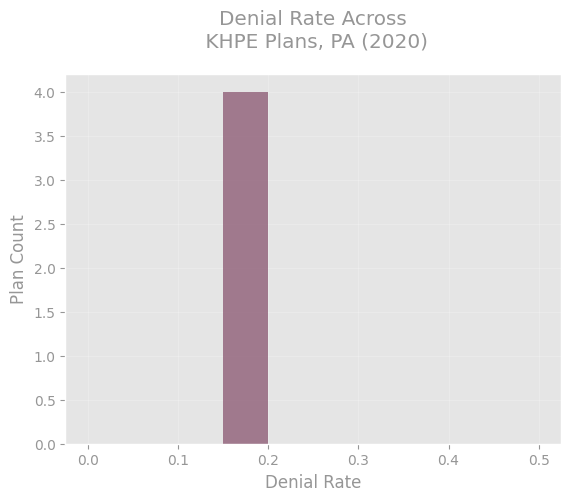

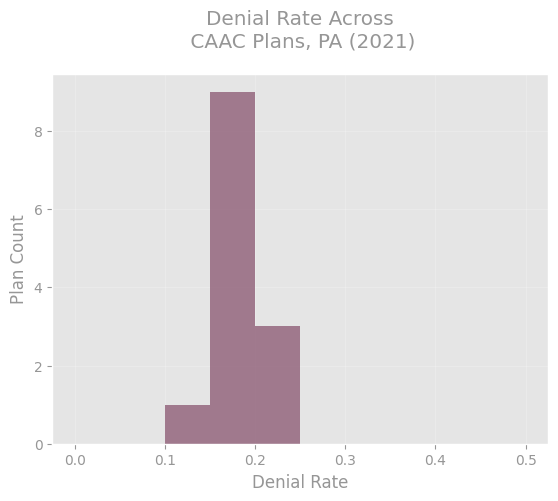

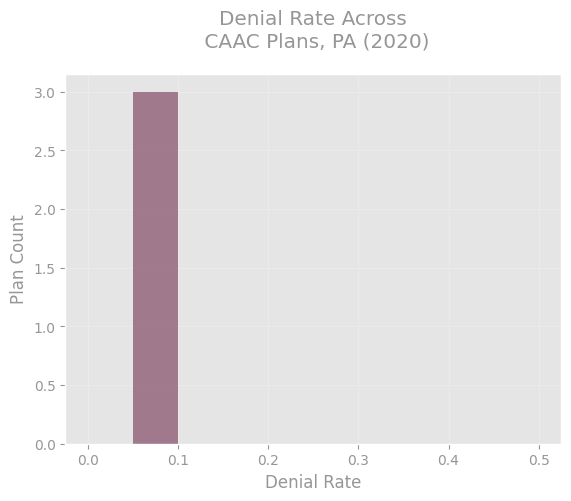

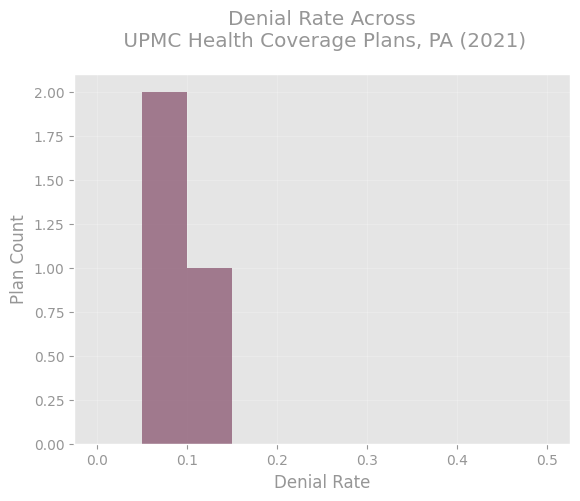

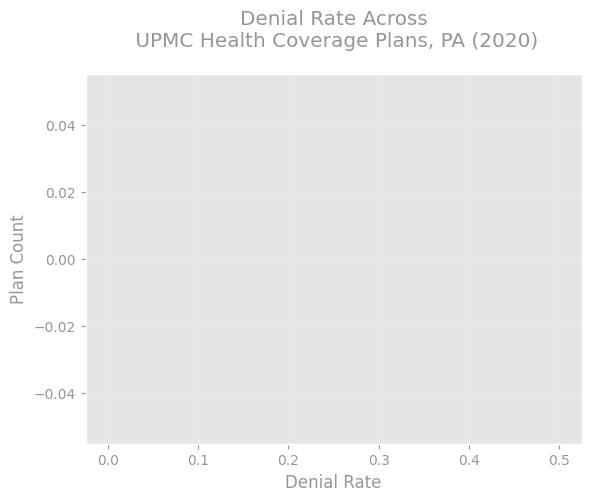

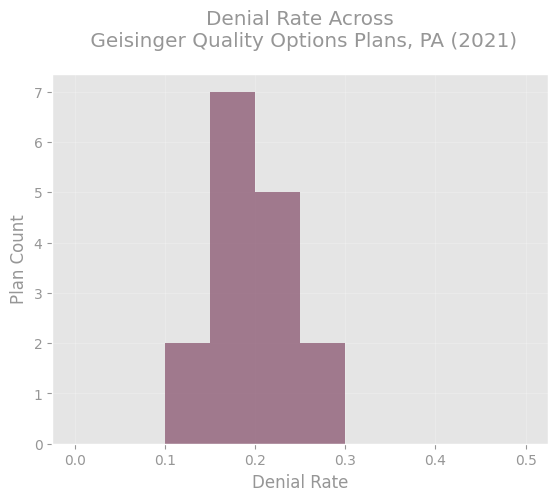

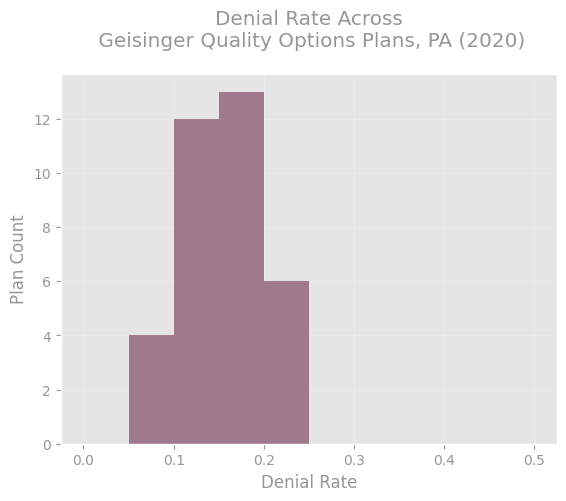

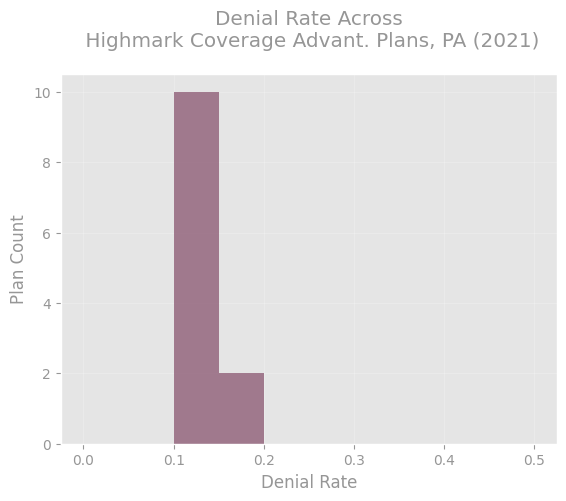

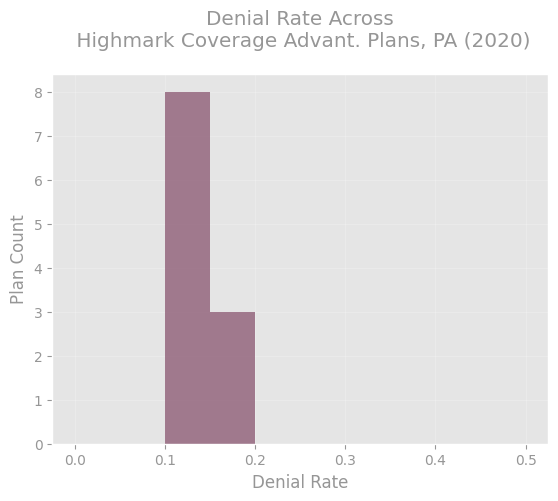

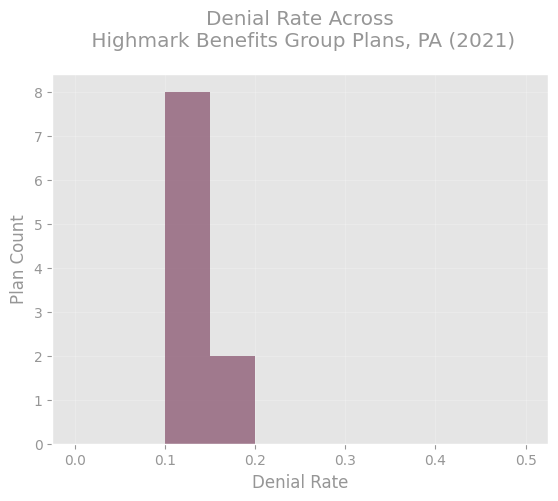

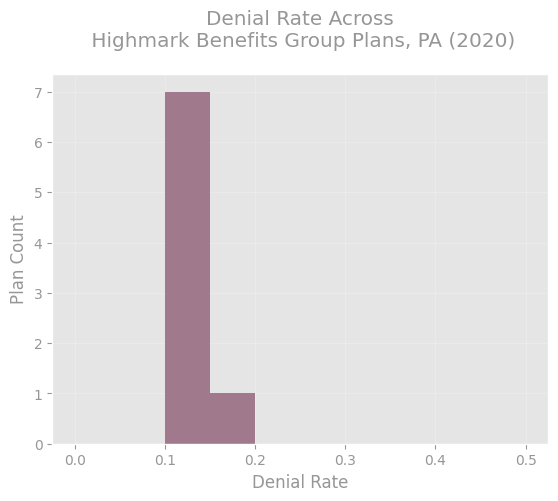

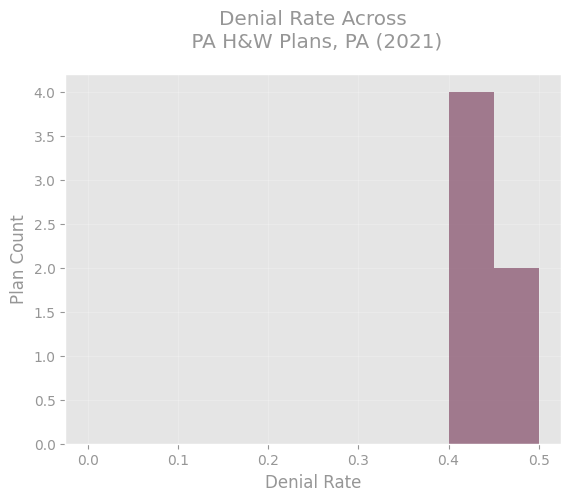

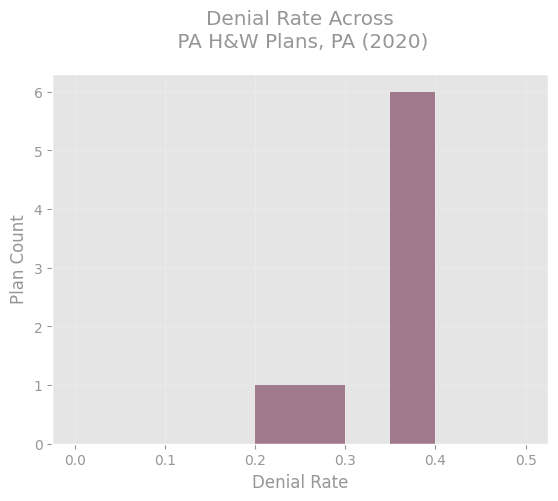

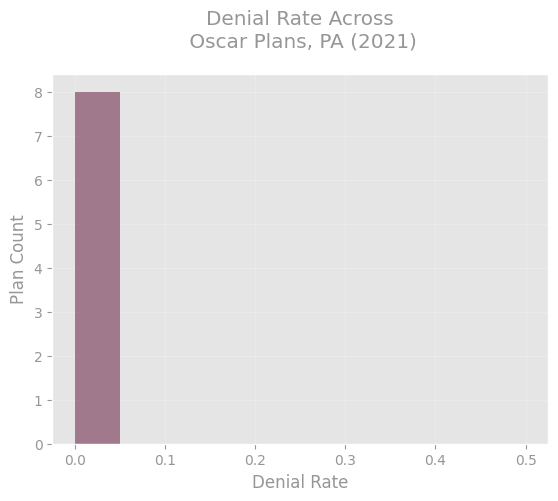

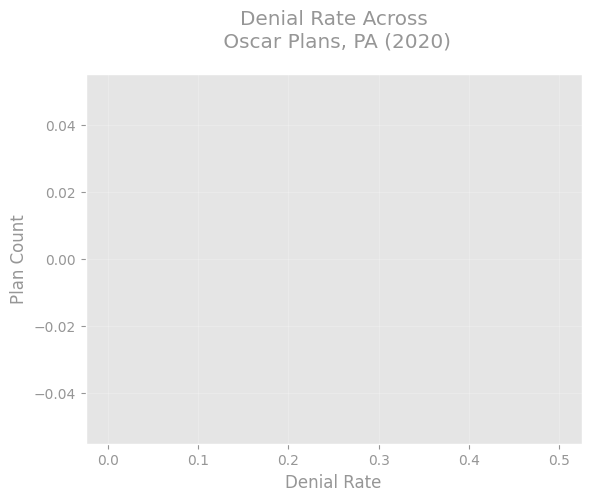

In [31]:
# Plot insurer histograms of plan denial rates, by year, for each insurer
for issuer_id in plan_df["hios_issuer_id"].unique():
    issuer_name = issuer_df[issuer_df["hios_id"] == issuer_id]["insurer_name"].iloc[0]
    for year_df in year_dfs:
        year = year_df["data_plan_year"].iloc[0]
        issuer_plans = year_df[year_df["hios_issuer_id"] == issuer_id]
        denial_rates = issuer_plans["denial_rate"]
        # Hist
        plot_hist(
            denial_rates,
            bins=np.linspace(0, 0.5, 11),
            title=f"Denial Rate Across\n {issuer_name} Plans, PA ({year})"
            if not NO_PLOT_TITLES
            else None,
            y_label="Plan Count",
            x_label="Denial Rate",
            save_path=os.path.join(
                OUTPUT_IMAGE_DIR,
                f"issuer_{issuer_name}_denial_rate_distribution_{year}.png",
            ),
        )